# 0. Environment Setup

## Mount Google Drive

To access the GitHub project and associated files, you need to mount your Google Drive to Colab. This process allows you to read and write files directly from your Google Drive within the Colab environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC-III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.

In [2]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/GitHub_Testing"

## Importing libraries.

In [3]:
%cd {BASE_PATH}/SepsisOnset_TraumaCohort

import os
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

# for dataset
# from scripts.all_icu_data import load_or_generate_nighttime_df
# for model
from tensorflow.keras.utils import to_categorical

# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/SepsisOnset_TraumaCohort')

/content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort


In [4]:
MODEL_FOLDER = '/content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model'
DATA_FOLDER = project_path_obj.final_dataset_path

## Load Dataset

### All ICU Data

In [5]:
file_path = os.path.join(DATA_FOLDER, 'nighttime_allICU_18to6H_7F_filled_final.pkl')

if os.path.exists(file_path):
    print(f"Loading existing nighttime data from {file_path}")
    night_ti_df = pd.read_pickle(file_path)
else:
    print(f"File not found: {file_path}")

print(night_ti_df.shape)
# Drop Nan
is_any_nan = night_ti_df['Temporal Features'].apply(lambda x: np.isnan(x).any())
night_df_filled = night_ti_df[~is_any_nan]
night_df_filled

Loading existing nighttime data from /content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort/dataset/nighttime_allICU_18to6H_7F_filled_final.pkl
(283062, 7)


subject_id  hadm_id  icustay_id        Date  Night  \
0            58526   100001      275225  2117-09-11      1   
2            58526   100001      275225  2117-09-13      3   
4            54610   100003      209281  2150-04-17      1   
5            54610   100003      209281  2150-04-18      2   
6             9895   100006      291788  2108-04-06      1   
...            ...      ...         ...         ...    ...   
283057       27200   199998      293589  2119-02-20      3   
283058       40370   199999      211153  2136-04-06      3   
283059       40370   199999      211153  2136-04-07      4   
283060       40370   199999      211153  2136-04-08      5   
283061       40370   199999      211153  2136-04-09      6   

                                        Temporal Features  \
0       [[112.0, 170.0, 86.0, 106.0, 16.0, 36.61111111...   
2       [[96.0, 171.0, 94.0, 113.0, 18.0, 37.388888888...   
4       [[72.0, 85.0, 43.5, 54.0, 14.666666666666666, ...   
5       [[85.0, 128.0, 56.0, 74.0, 16.0, 36.3888888888...   
6       [[122.0, 124.0, 70.0, 88.0, 18.0, 36.111111111...   
...                                                   ...   
283057  [[85.0, 146.0, 57.5, 85.0, 19.0, 37.5999984741...   
283058  [[64.0, 134.0, 51.0, 73.0, 17.0, 36.5555555555...   
283059  [[67.0, 143.0, 52.0, 74.0, 28.0, 36.4444444444...   
283060  [[80.0, 167.0, 54.0, 84.0, 23.0, 36.5, 95.0], ...   
283061  [[90.0, 146.0, 53.0, 79.0, 24.0, 36.6666666666...   

                                                    isNan  
0       [[False, False, False, False, False, True, Fal...  
2       [[False, False, False, False, True, True, True...  
4       [[False, False, False, False, False, True, Fal...  
5       [[False, False, False, False, False, True, Fal...  
6       [[False, False, False, False, False, True, Fal...  
...                                                   ...  
283057  [[False, False, False, False, False, False, Fa...  
283058  [[False, False, False, False, False, True, Fal...  
283059  [[False, False, False, False, False, False, Fa...  
283060  [[False, False, False, False, False, True, Fal...  
283061  [[False, False, False, False, False, True, Fal...  

[212115 rows x 7 columns]

### Trauma Cohot
In this section, we will load the complete Post-Traumatic Sepsis dataset (without missing values), which is derived from the MIMIC-III v1.4 dataset. For a comprehensive explanation of the dataset construction and additional relevant information, please refer to the `notebooks/Early_Sepsis_Onset_Detection_Setup.ipynb` file.

The dataset table comprises the following columns:

- **Temporal Features**: Multivariate time-series input data with dimensions (# of timestamps, # of features).

Each row in the dataset corresponds to one nighttime instance, and includes patient identifiers (`subject_id`, `hadm_id`) and a timestamp ID (`Date`, `Night`).

In [6]:
file_path = os.path.join(DATA_FOLDER, 'PostTraumaticSepsis_dataset_wo_nan.pkl')

if os.path.exists(file_path):
    print(f"Loading existing nighttime data from {file_path}")
    truma_cohort_df = pd.read_pickle(file_path)
else:
    print(f"File not found: {file_path}")

truma_cohort_ids = truma_cohort_df.hadm_id.unique()
positive_samples = truma_cohort_df[truma_cohort_df.Label == 1]
print("# of truma", truma_cohort_ids.shape[0],
      f"# of positive sample {positive_samples.shape[0]} of sepsis pacient {positive_samples.hadm_id.nunique()}")
truma_cohort_df.head()

Loading existing nighttime data from /content/drive/MyDrive/GitHub_Testing/SepsisOnset_TraumaCohort/dataset/PostTraumaticSepsis_dataset_wo_nan.pkl
# of truma 1522 # of positive sample 440 of sepsis pacient 440


subject_id  hadm_id        Date Night  \
0       19984   100132  2179-03-06   002   
1       19984   100132  2179-03-07   003   
2       19984   100132  2179-03-08   004   
3       19984   100132  2179-03-09   005   
4       19984   100132  2179-03-10   006   

                                   Temporal Features  \
0  [[90.0, 142.0, 73.0, 99.0, 16.0, 37.5555547078...   
1  [[97.0, 129.0, 61.0, 86.0, 20.0, 36.2222205268...   
2  [[68.0, 87.0, 47.0, 60.33330154418945, 15.0, 3...   
3  [[96.0, 133.0, 71.0, 91.6667022705078, 22.0, 3...   
4  [[107.0, 188.0, 85.0, 119.33300018310548, 23.0...   

                                               isNan  Label onset_datetime  \
0  [[0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, ...      0            NaN   
1  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   
2  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   
3  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   
4  [[0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, ...      0            NaN   

   Fold  
0     3  
1     3  
2     3  
3     3  
4     3

In [7]:
truma_subject_ids = truma_cohort_df.subject_id.unique()

truma_records = night_df_filled[night_df_filled.subject_id.isin(truma_subject_ids)]
nontruma_records = night_df_filled[~night_df_filled.subject_id.isin(truma_subject_ids)]
print(truma_records.shape, nontruma_records.shape)

(19759, 7) (192356, 7)


## Sample

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nighttime_features(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    title: str = "Nighttime Features (6 pm → 6 am)"
) -> pd.DataFrame:
    """
    Build a DataFrame indexed from start_hour through next-day 6 am,
    then plot all features over that 13-hour window.

    Parameters
    ----------
    sample : array-like, shape (T=13, F)
        2D array of T hourly measurements.
    feature_names : list of str, length F
        Column names for each feature.
    start_hour : int, optional
        Hour to start labeling (default 18 for 6 pm).
    title : str, optional
        Plot title.

    Returns
    -------
    sample_df : pd.DataFrame
        DataFrame of the sample, indexed by hour labels.
    """
    T = sample.shape[0]
    # generate labels "18:00, 19:00, …, 23:00, 00:00, …, 06:00"
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # build DataFrame with custom index
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)
    # display(sample_df)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    for col in sample_df.columns:
        ax.plot(sample_df.index, sample_df[col], label=col)

    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1),   # (x, y) relative to axes

              )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return sample_df

(13, 7)


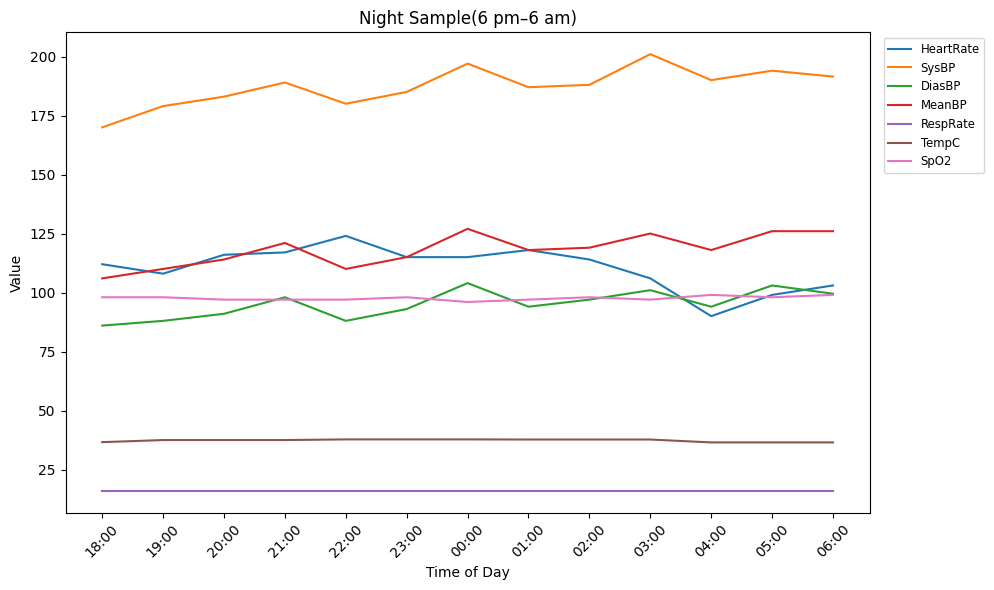

HeartRate  SysBP  DiasBP  MeanBP  RespRate      TempC  SpO2
18:00      112.0  170.0    86.0   106.0      16.0  36.611111  98.0
19:00      108.0  179.0    88.0   110.0      16.0  37.500000  98.0
20:00      116.0  183.0    91.0   114.0      16.0  37.500000  97.0
21:00      117.0  189.0    98.0   121.0      16.0  37.500000  97.0
22:00      124.0  180.0    88.0   110.0      16.0  37.777778  97.0
23:00      115.0  185.0    93.0   115.0      16.0  37.777778  98.0
00:00      115.0  197.0   104.0   127.0      16.0  37.777778  96.0
01:00      118.0  187.0    94.0   118.0      16.0  37.722222  97.0
02:00      114.0  188.0    97.0   119.0      16.0  37.722222  98.0
03:00      106.0  201.0   101.0   125.0      16.0  37.722222  97.0
04:00       90.0  190.0    94.0   118.0      16.0  36.500000  99.0
05:00       99.0  194.0   103.0   126.0      16.0  36.500000  98.0
06:00      103.0  191.5    99.5   126.0      16.0  36.500000  99.0

In [9]:
print(night_df_filled['Temporal Features'][0].shape) #T:13(6pm-6am), F:['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2']

sample = night_df_filled['Temporal Features'][0]
feature_names = ['HeartRate', 'SysBP', 'DiasBP', 'MeanBP',
                 'RespRate', 'TempC', 'SpO2', #'Glucose', 'fio2'
                 ]
plot_nighttime_features(sample, feature_names=feature_names,
                        start_hour=18, title= "Night Sample(6 pm–6 am)")

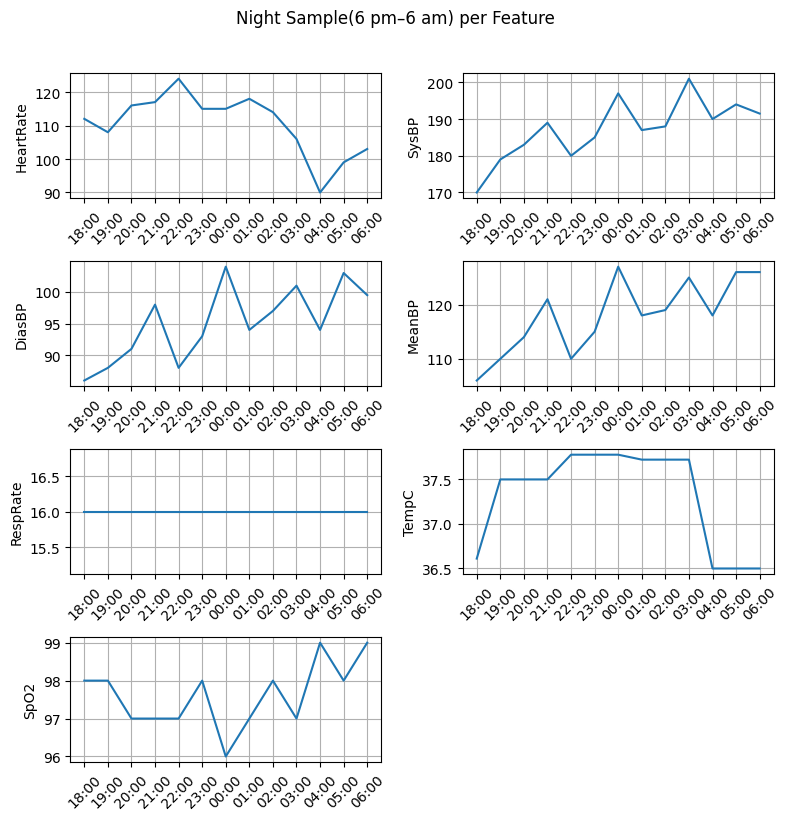

HeartRate  SysBP  DiasBP  MeanBP  RespRate      TempC  SpO2
18:00      112.0  170.0    86.0   106.0      16.0  36.611111  98.0
19:00      108.0  179.0    88.0   110.0      16.0  37.500000  98.0
20:00      116.0  183.0    91.0   114.0      16.0  37.500000  97.0
21:00      117.0  189.0    98.0   121.0      16.0  37.500000  97.0
22:00      124.0  180.0    88.0   110.0      16.0  37.777778  97.0
23:00      115.0  185.0    93.0   115.0      16.0  37.777778  98.0
00:00      115.0  197.0   104.0   127.0      16.0  37.777778  96.0
01:00      118.0  187.0    94.0   118.0      16.0  37.722222  97.0
02:00      114.0  188.0    97.0   119.0      16.0  37.722222  98.0
03:00      106.0  201.0   101.0   125.0      16.0  37.722222  97.0
04:00       90.0  190.0    94.0   118.0      16.0  36.500000  99.0
05:00       99.0  194.0   103.0   126.0      16.0  36.500000  98.0
06:00      103.0  191.5    99.5   126.0      16.0  36.500000  99.0

In [10]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_nighttime_features_subplots(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> pd.DataFrame:
    """
    Plot each feature in its own subplot over the 13-hour window,
    arranged in a grid with `ncols` columns.
    Each subplot shows its own x-axis labels.

    Returns the DataFrame for further inspection.
    """
    T, F = sample.shape
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)

    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, col in enumerate(feature_names):
        ax = axes_flat[idx]
        ax.plot(range(T), sample_df[col], label=col)
        ax.set_ylabel(col)
        ax.grid(True)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)

    # 关闭多余的子图
    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return sample_df


plot_nighttime_features_subplots(sample, feature_names=feature_names,
                        start_hour=18, title_prefix= "Night Sample(6 pm–6 am)")

In [11]:
# corrspondng features list: 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2', 'Glucose', 'fio2'
start_hour, T = 18,13
pd.DataFrame(night_df_filled.isNan[0], columns=['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2',
                                                # 'Glucose', 'fio2'
                                                ],
             index=[f"{(start_hour + i) % 24:02d}:00" for i in range(T)])
# False: means not nan, or have raw data
# True: is nan, data is filled

HeartRate  SysBP  DiasBP  MeanBP  RespRate  TempC   SpO2
18:00      False  False   False   False     False   True  False
19:00      False  False   False   False      True  False   True
20:00      False  False   False   False      True   True  False
21:00      False  False   False   False      True   True   True
22:00      False  False   False   False      True  False  False
23:00      False  False   False   False      True   True  False
00:00      False  False   False   False      True   True  False
01:00      False  False   False   False      True  False  False
02:00      False  False   False   False      True   True  False
03:00      False  False   False   False      True   True  False
04:00      False  False   False   False      True  False  False
05:00      False  False   False   False      True   True  False
06:00      False  False   False    True      True   True  False

# Model

## Model Definition

### Autoencoder

In [12]:
keras.layers.GRU

keras.src.layers.rnn.gru.GRU

In [13]:
from keras import layers, models, Input
from keras.regularizers import l2

def Encoder_model(input_shape, name="encoder", drop_r=0.2):
    input_layer = Input(shape=input_shape)
    x = input_layer

    # LSTM Feature Extraction
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)

    # Feed Forward Part
    # FCL
    # x = layers.Dense(units=512, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(units=32, activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    # CNN
    # Feed Forward Part
    x = layers.Conv1D(filters=128, kernel_size=3, strides=1,
                      activation="relu", kernel_regularizer=l2(0.01),
                      # dilation_rate=1
                      )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, strides=2,
                      # dilation_rate=1s
                      )(x)
    x = layers.BatchNormalization()(x)

    # Output Feature Representation Vector
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    # x = layers.GlobalMaxPooling1D()(x)

    return models.Model(input_layer, x, name=name)

# def Decoder_model(T=9, F=6, feature_vector_shape=32, drop_r=0.2):
#     latent_inputs = Input(shape=feature_vector_shape[1:])
#     x = layers.RepeatVector(n=T)(latent_inputs)
#     x = layers.LSTM(units=256, return_sequences=True, kernel_regularizer=l2(0.01))(x)
#     x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(rate=drop_r)(x)
#     x = layers.Bidirectional(layers.LSTM(units=1024, return_sequences=True, kernel_regularizer=l2(0.01)))(x)
#     x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(rate=drop_r)(x)
#     dec_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)
#     return models.Model(latent_inputs, dec_output, name="decoder")


def multimodal_AutoEncoder(input_shape_li, drop_r=0.2):
    # Create input layers for each encoder
    raw_inputs = layers.Input(shape=input_shape_li[0])
    delta_inputs = layers.Input(shape=input_shape_li[1])
    inputs = [raw_inputs, delta_inputs]

    # Init Encoders
    raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
    delta_encoder = Encoder_model(input_shape_li[1], name="delta_encoder")
    encoders = [raw_encoder, delta_encoder]

    # Pass inputs through respective encoders
    embeddings = [raw_encoder(raw_inputs),
                  delta_encoder(delta_inputs)]
    # Combine the embeddings (using Concatenate)
    combined_emb = layers.Concatenate()(embeddings)
    # # Combine the embeddings (using Add)
    # combined_emb = layers.Add()(embeddings)

    # Decoder
    # feature_vector_shape=encoder.output_shape
    # latent_inputs = Input(shape=feature_vector_shape[1:])
    T, F = input_shape_li[0]
    x = layers.RepeatVector(n=T)(combined_emb)
    # x = layers.LSTM(units=1, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    decoder_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)

    # Autoencoder
    autoencoder = models.Model(inputs, decoder_output, name="autoencoder")
    return encoders, autoencoder

# input_shape_li = [(13, 7), (13,7)] # T,F
# encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)

In [14]:
night_df_filled['Temporal Features'][0].shape

(13, 7)

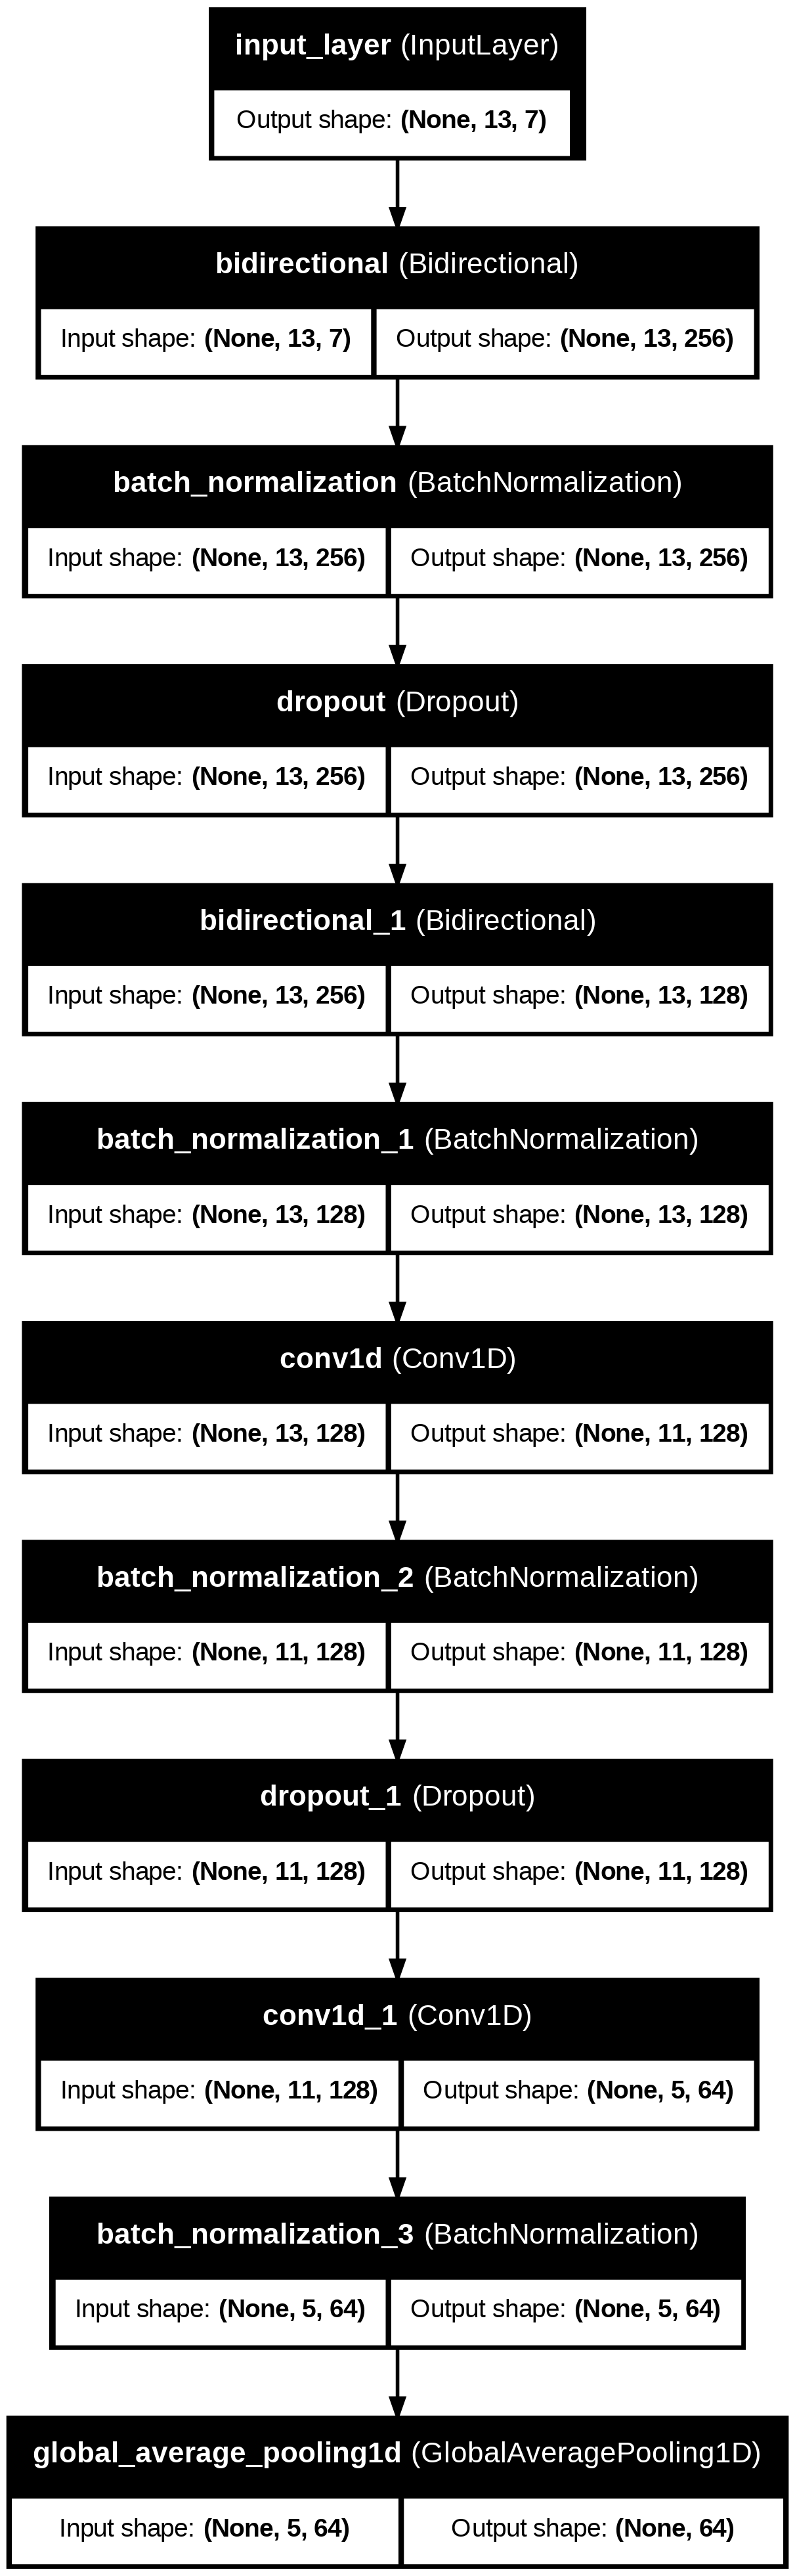

In [15]:
input_shape_li = [(13, 7), (13,7)]
# encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
keras.utils.plot_model(raw_encoder, show_shapes=True, show_layer_names=True)

Model: "night_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 13, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 13, 256)        │       105,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 13, 128)        │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,088 (1.16 MB)

 Trainable params: 303,936 (1.16 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 13, 128)   │          0 │ concatenate[0][0] │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 13, 128)   │     74,496 │ repeat_vector[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 128)   │        512 │ bidirectional_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 13, 256)   │    198,144 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 256)   │      1,024 │ bidirectional_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 13, 7)     │      1,799 │ batch_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 886,151 (3.38 MB)

 Trainable params: 883,079 (3.37 MB)

 Non-trainable params: 3,072 (12.00 KB)

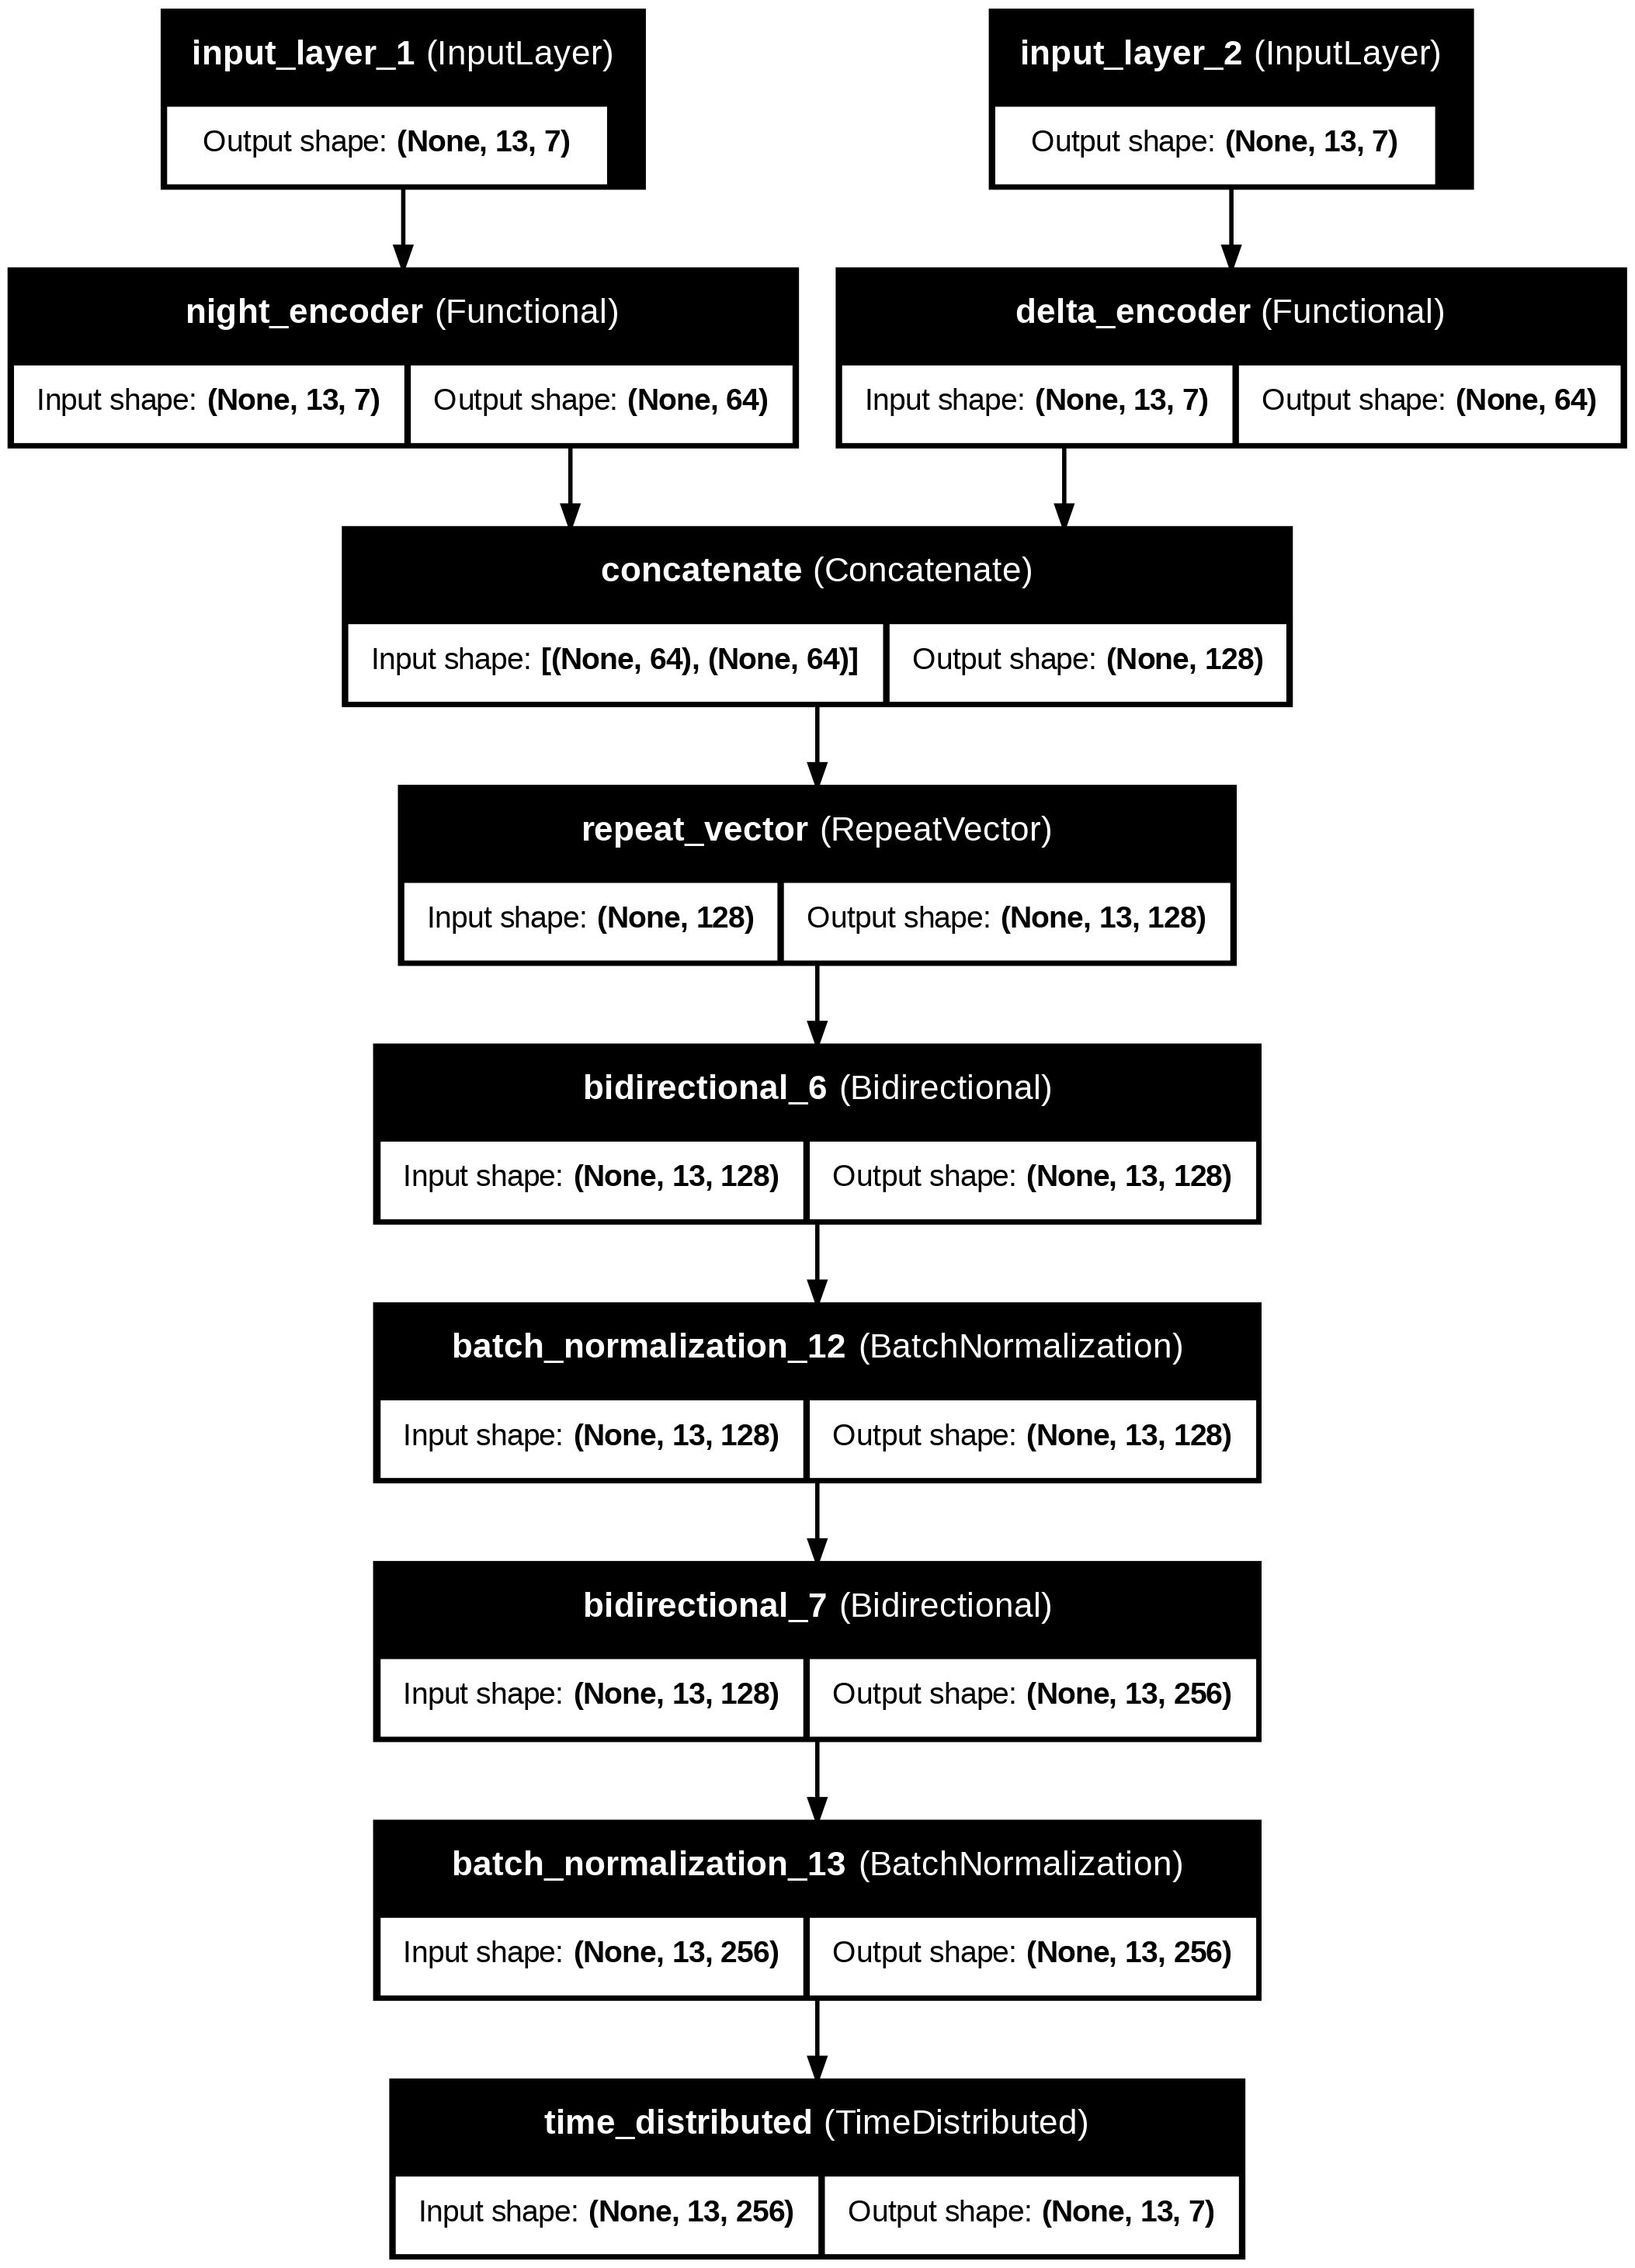

In [16]:
# Instantiate the models
input_shape_li = [(13, 7), (13,7)]
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li)

# # Print summary of the autoencoder model
encoders[0].summary()
# encoders[1].summary()
autoencoder.summary()

keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True)

### Classification

Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_6[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None


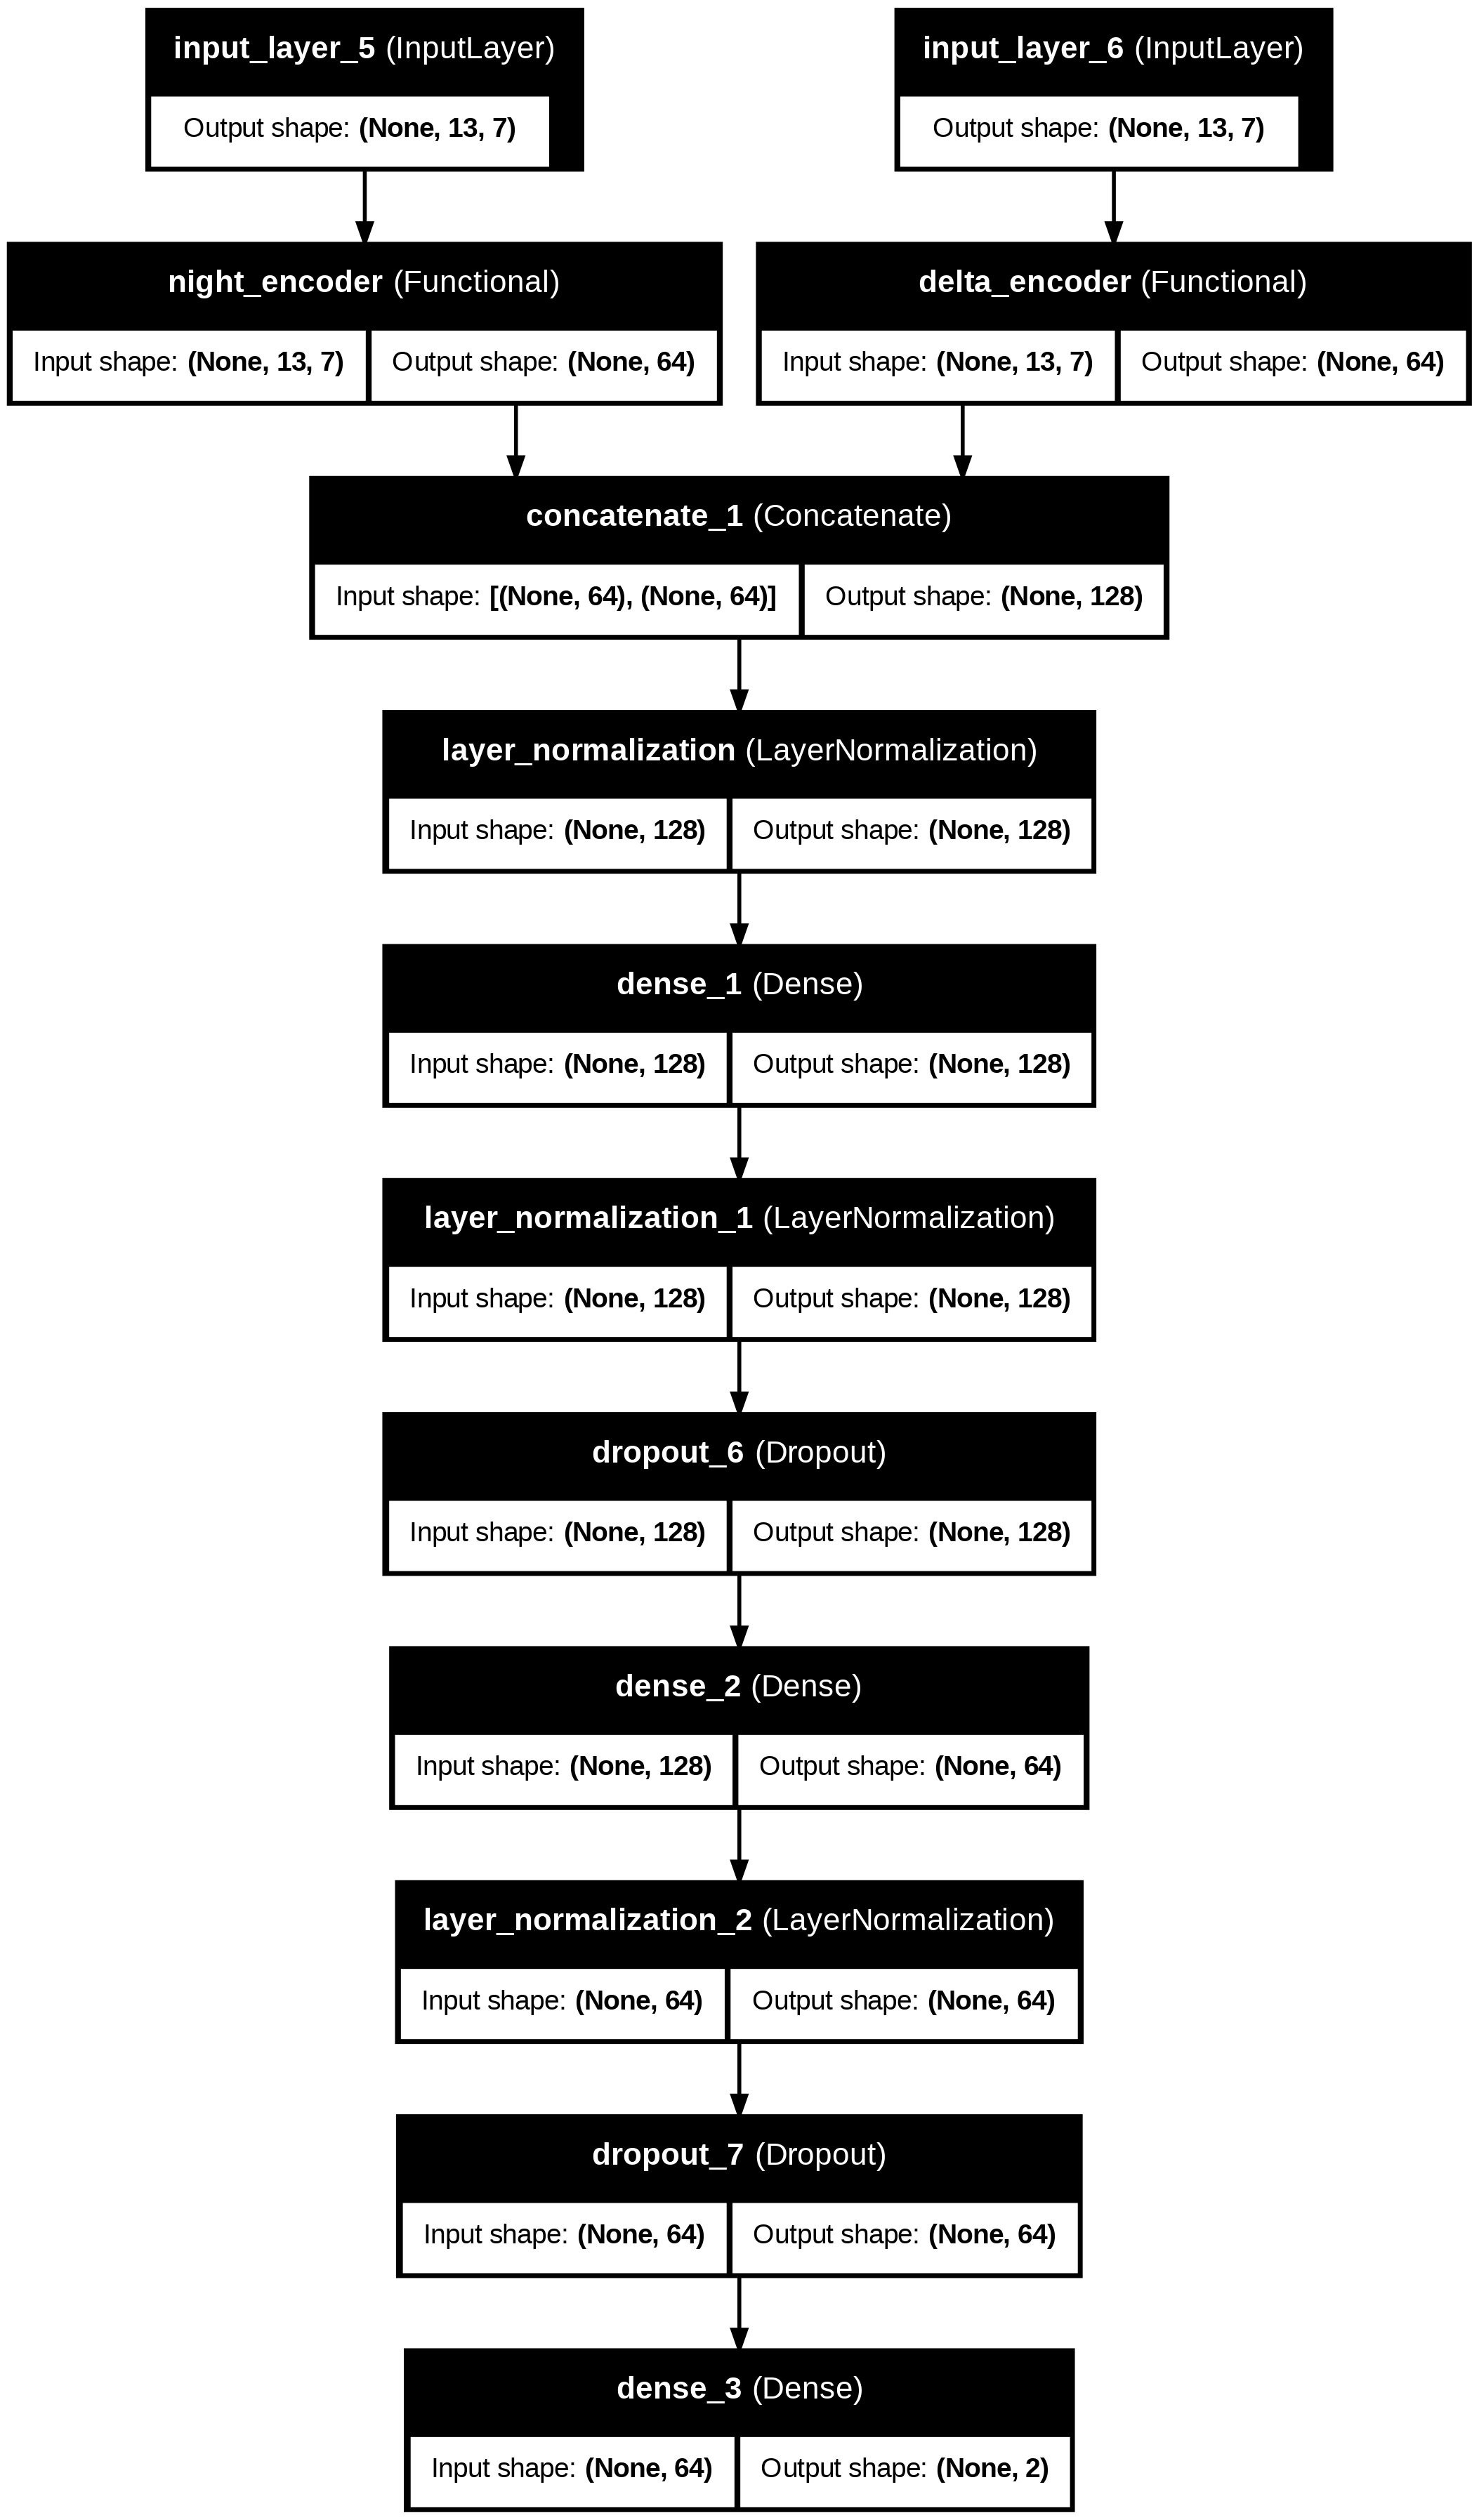

In [17]:
def classification_2encoder(input_shape_li, encoders,
                            freeze_encoders = False,
                            mlp_units=[128, 64],
                            mlp_dropout_rate=0.5, regularizers_l2=0.001):
    """
    Builds a classification model using a pre-trained encoder followed by fully connected layers.

    Args:
        input_shape_li (tuple): Shape of the input data (excluding batch size).
        encoder (Model): Pre-trained encoder model to extract features.
        mlp_units (list): List of integers defining the units in the MLP layers.
        mlp_dropout_rate (float): Dropout rate for the MLP layers.
        regularizers_l2 (float): L2 regularization factor for the Dense layers.

    Returns:
        Model: A Keras Model instance for classification.
    """
    # Create input layers for each encoder
    raw_inputs = layers.Input(shape=input_shape_li[0])
    delta_inputs = layers.Input(shape=input_shape_li[1])
    inputs = [raw_inputs, delta_inputs]

    # Init Encoders
    raw_encoder, delta_encoder = encoders
    if freeze_encoders:
        raw_encoder.trainable = False
        delta_encoder.trainable = False

    # Pass inputs through respective encoders
    embeddings = [raw_encoder(raw_inputs),
                  delta_encoder(delta_inputs)]
    # # Combine the embeddings (using Concatenate)
    combined_emb = layers.Concatenate()(embeddings)
    # # Combine the embeddings (using Add)
    # combined_emb = layers.Add()(embeddings)
    x = layers.LayerNormalization()(combined_emb)

    # Fully connected output layer
    for units in mlp_units:
        x = layers.Dense(units, activation="relu", kernel_regularizer=l2(regularizers_l2))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(mlp_dropout_rate)(x)
    outputs = layers.Dense(2, activation="softmax")(x)

    model = models.Model(inputs=inputs,
                         outputs=outputs,
                         name='dual_encoder_classifier')
    return model

input_shape_li = ((13, 7), (13, 7))
# encoders, _ = load_models(os.path.join(MODEL_FOLDER, f'MAE_nontruma_Jul9'), load_autoencoder=False)
classification_model = classification_2encoder(input_shape_li, encoders, freeze_encoders=True)
print(classification_model.summary())
keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

## Custom Fit and Loss Functions

In [18]:
# def masked_mae(y_true, y_pred, mask, alpha=1.0):
#     """
#     Weighted MAE for Masked-AE.
#     alpha = mask_weight_para in [0, 1]:
#         1.0 → loss from masked positions only
#         0.5 → half masked, half visible
#         0.0 → all positions equally
#     """
#     # element-wise L1 error
#     err = tf.abs(y_true - y_pred)

#     # visible = 1, masked = 0  ▸ convert to float32
#     mask = tf.cast(mask, tf.float32)

#     # build weights: w = (1-alpha)·visible + alpha·masked
#     weights = (1.0 - alpha) * mask + alpha * (1.0 - mask)

#     # masked mean
#     loss = tf.reduce_sum(err * weights) / tf.reduce_sum(weights)
#     return loss


In [19]:
# class MaskedReconstructionFit(tf.keras.Model):
#     def __init__(self, model, alpha=1.0):
#         super(MaskedReconstructionFit, self).__init__()
#         self.model = model
#         self.alpha = alpha         # mask_weight_para
#         # self.loss_fn = weight_mae
#         # self.test_loss_fn = tf.keras.losses.MeanAbsoluteError()
#         self.metric = tf.keras.metrics.MeanAbsoluteError()

#     def compile(self, optimizer, metrics=None, **kwargs):
#         super().compile(optimizer=optimizer, metrics=metrics, **kwargs)

#     def train_step(self, data):
#         (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
#         mask = tf.cast(mask, tf.float32)
#         masked_x = x * mask  # Apply the mask to the input
#         # masked_x_delta = x_delta * mask
#         # tf.print("Masked input (masked_x):", masked_x, summarize=-1)  # summarize=-1 prints the full tensor

#         with tf.GradientTape() as tape:
#             x_hat = self.model([masked_x, x_delta], training=True)
#             loss  = masked_mae(x, x_hat, mask, self.alpha)

#         # Compute gradients and update weights
#         gradients = tape.gradient(loss, self.model.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

#         # Update the reconstruction loss metric
#         self.metric.update_state(x, x_hat)
#         # Return the reconstruction loss as the only metric
#         return {"loss": loss, "global_MAE": self.metric.result()}



#     def test_step(self, data):
#         (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
#         mask = tf.cast(mask, tf.float32)
#         x_visible = x * mask              # zero-out masked positions

#         x_hat = self.model([x_visible, x_delta], training=False)
#         loss  = masked_mae(x, x_hat, mask, self.alpha)

#         # Update the reconstruction loss metric
#         self.metric.update_state(x, x_hat)
#         # ---- build log dict (TOP-LEVEL keys!) ----
#         return {"loss": loss, "global_MAE":self.metric.result()}


## Evaluation and Learning Curve Plotting Function

In [20]:
def plot_learning_curves(training_history, log_history=None, name='', metric_name_li=[], init_index=0):
    """
    Plots the learning curves for training and validation loss/accuracy.

    Parameters:
    - training_history: The history object returned from model.fit.

    Returns:
    - None (Displays the plots).
    """
    if log_history is not None:
        history_data = log_history
    else:
        history_data = training_history.history

    # Loop through each metric in the history
    if len(metric_name_li) == 0:
      for metric_name in history_data.keys():
          if 'val' not in metric_name:
              metric_name_li.append(metric_name)

    for metric_name in metric_name_li:
            epochs = range(init_index+1, len(history_data[metric_name]) + 1)
            # print(len(epochs), len(history_data[metric_name][init_index:]))

            # Create a new figure for each metric
            metric_fig = plt.figure(figsize=(4, 3))
            plt.plot(epochs, history_data[metric_name][init_index:], label=f'Training {metric_name}')
            plt.plot(epochs, history_data[f'val_{metric_name}'][init_index:], label=f'Validation {metric_name}')

            # Formatting the plot
            plt.title(f'{metric_name.capitalize()}-{name}')
            plt.xlabel('Epochs')
            plt.ylabel(metric_name.capitalize())
            plt.legend()
            plt.grid(True)

            # Display the plot
            # metric_fig.tight_layout()
            metric_fig.show()
    return

# plot_learning_curves(history, init_index=5)

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
def evaluate_model(y_true, y_pred_probs, metrics):
    """
    Evaluates the model's performance using various metrics and updates the metrics dictionary.

    Parameters:
    - y_true: True labels (numpy array or list).
    - y_pred_probs: Predicted probabilities (numpy array).
    - metrics: Dictionary to update with evaluation metrics.

    Returns:
    - None
    """
    # Convert probabilities to binary predictions
    y_pred = np.argmax(y_pred_probs, axis=1)
    # Keep only probability for positive class
    y_pred_pos = y_pred_probs[:, 1]

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['tn'].append(tn)
    metrics['fp'].append(fp)
    metrics['fn'].append(fn)
    metrics['tp'].append(tp)

    # Calculate precision and recall
    specificity, sensitivity = recall_score(y_true, y_pred, average=None) #recall for both
    metrics['sensitivity'].append(sensitivity)
    metrics['specificity'].append(specificity)
    precision = precision_score(y_true, y_pred) #only for positive class
    metrics['precision'].append(precision)
    f1 = f1_score(y_true, y_pred)
    metrics['f1_score'].append(f1)

    # PR curve
    precision_li, recall_li, thresholds_pr = precision_recall_curve(y_true, y_pred_pos)
    pr_auc = auc(recall_li, precision_li)
    metrics['PR_auc'].append(pr_auc)

    # ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_pos)
    roc_auc = auc(fpr, tpr)
    metrics['ROC_auc'].append(roc_auc)

    # Store metrics in a DataFrame
    metrics_data = {
        "Metric": [
            "True Negatives", "False Positives", "False Negatives", "True Positives",
            "Sensitivity", "Specificity", "Precision", "F1 Score", "PR AUC", "ROC AUC"
        ],
        "Value": [tn, fp, fn, tp, sensitivity, specificity, precision, f1, pr_auc, roc_auc]
    }
    display(pd.DataFrame(metrics_data))

    return

## Save Model

In [22]:
from tensorflow.keras.models import save_model

def save_models(encoders, autoencoder, save_dir):
    """
    Saves encoders (list of two models) and autoencoder model to the given directory.

    Parameters:
    - encoders (list): A list containing two Keras models (encoder models).
    - autoencoder (Model): The main autoencoder model.
    - save_dir (str): Directory path where models will be saved.

    Returns:
    - None (saves models to disk).
    """

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save encoder models
    save_model(encoders[0], os.path.join(save_dir, "encoder_1.h5"))
    save_model(encoders[1], os.path.join(save_dir, "encoder_2.h5"))

    # Save autoencoder model
    save_model(autoencoder, os.path.join(save_dir, "autoencoder.h5"))

    print(f"Models saved in: {save_dir}")


from tensorflow.keras.models import load_model
def load_models(load_dir, load_autoencoder=True):
    """
    Loads two encoder models and optionally an autoencoder model from the specified directory.

    Parameters:
    - load_dir (str): Directory path where models are saved.
    - load_autoencoder (bool): Whether to load the autoencoder model (default is True).

    Returns:
    - encoders (list): A list containing two loaded encoder models.
    - autoencoder (Model or None): The loaded autoencoder model if `load_autoencoder=True`, else None.
    """

    # Ensure the directory exists
    if not os.path.exists(load_dir):
        raise FileNotFoundError(f"Directory {load_dir} does not exist. Please check the path.")

    # Load encoder models
    encoder_1 = load_model(os.path.join(load_dir, "encoder_1.h5"))
    encoder_2 = load_model(os.path.join(load_dir, "encoder_2.h5"))

    encoders = [encoder_1, encoder_2]

    # Load autoencoder model if specified
    autoencoder = None
    if load_autoencoder:
        autoencoder = load_model(os.path.join(load_dir, "autoencoder.h5"))
        print(f"Autoencoder loaded successfully from: {load_dir}")

    print(f"Encoders loaded successfully from: {load_dir}")

    return encoders, autoencoder


# Data Preprocess

## Sampling with mask strategy

In [23]:
from sklearn.utils import shuffle

def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked
    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    # np.random.seed(seed)
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask

def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (seq_length, feat_dim) numpy array of features corresponding to a single sample
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at a certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked squences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)
    Returns:
        boolean numpy array with the same shape as X, with 0s at places where a feature should be masked
    """
    # np.random.seed(seed)
    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = np.ones(X.shape, dtype=bool)
            for m in range(X.shape[1]):  # feature dimension
                if exclude_feats is None or m not in exclude_feats:
                    mask[:, m] = geom_noise_mask_single(X.shape[0], lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask = np.tile(np.expand_dims(geom_noise_mask_single(X.shape[0], lm, masking_ratio), 1), X.shape[1])
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = np.random.choice(np.array([True, False]), size=X.shape, replace=True,
                                    p=(1 - masking_ratio, masking_ratio))
        else:
            mask = np.tile(np.random.choice(np.array([True, False]), size=(X.shape[0], 1), replace=True,
                                            p=(1 - masking_ratio, masking_ratio)), X.shape[1])

    return mask

def Gen_Mask(X, r=0.15, lm=2):
  '''
  Gen mask Matrix for a given training sample
  '''
  M = noise_mask(X, r, lm, mode='separate', distribution='geometric', exclude_feats=None)
  M = np.where(M, 1, 0)
  return M

def Gen_Masked_data(X, M):
  '''
  Gen mask input Matrix as target for lossfunction for training process
  '''
  Y = np.multiply(X, np.subtract(1, M))
  return Y

def Gen_Unmask_Data(X, M):
  '''
  Gen un-mask Matrix for training process
  '''
  X = np.multiply(X,M)
  return X

## Normalization

In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_features_array(train_X: np.ndarray,
                             val_X:   np.ndarray,
                             test_X:  np.ndarray,
                             eps: float = 0.05):
    """
    Min–max-scales each feature to the interval [eps, 1].

    Parameters
    ----------
    train_X, val_X, test_X : np.ndarray
        Arrays with shape (N, T, F).
    eps : float, optional
        Lower bound of the scaled range (default 0.05).

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        Normalised (train, val, test) arrays.
    """
    # reshape to 2-D (samples × features)
    N, T, F = train_X.shape
    train_flat = train_X.reshape(-1, F)

    # fit scaler on *training* data only
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    train_flat_norm = scaler.fit_transform(train_flat)

    # apply the same scaler to val
    val_flat_norm  = scaler.transform(val_X.reshape(-1, F))

    # reshape back to (N, T, F)
    train_norm = train_flat_norm.reshape(N, T, F)
    val_norm   = val_flat_norm.reshape(val_X.shape[0], T, F)

    if test_X is not None:
      test_flat_norm = scaler.transform(test_X.reshape(-1, F))
      test_norm  = test_flat_norm.reshape(test_X.shape[0], T, F)
    else:
      test_norm = None

    return train_norm, val_norm, test_norm


def denormalize_with_trained_scaler(
    X_norm:    np.ndarray,  # (N, T, F) — data in [eps, 1]
    train_X:   np.ndarray,  # (N_train, T, F) — raw training set
    eps: float = 0.05
) -> np.ndarray:
    """
    1. Reshape raw training data to (samples, features).
    2. Fit MinMaxScaler(feature_range=(eps, 1.0)) on it.
    3. Apply inverse_transform to X_norm and reshape back.

    Returns
    -------
    X_raw  : de-normalised array, same shape as X_norm.
    scaler : the fitted MinMaxScaler (handy for later use).
    """
    # reshape training data
    N_train, T, F = train_X.shape
    train_flat = train_X.reshape(-1, F)

    # fit scaler
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    scaler.fit(train_flat)

    # inverse-transform the normalised array
    X_raw = scaler.inverse_transform(X_norm.reshape(-1, F)).reshape(X_norm.shape)
    return X_raw

# Preprocess 2 Night data

In [25]:
def generate_2night_data(df):
    df = df.reset_index()
    # Extract previous day data
    previous_day_df = df.shift(1).iloc[1:]
    previous_day_df['Night'] = previous_day_df['Night'].astype(int)

    df = df.iloc[1:]
    df['PreviousNight'] = previous_day_df['Night']

    # Generate 2 night
    TwoNight_df = pd.DataFrame()
    TwoNight_df['subject_id'] = df.subject_id
    TwoNight_df['hadm_id'] = df.hadm_id
    TwoNight_df['Night'] = df.apply(lambda row: f"{row.PreviousNight}--{row.Night}", axis=1)
    TwoNight_df['PreviousNight'] = previous_day_df['Temporal Features']
    TwoNight_df['CurrentNight'] = df['Temporal Features']
    TwoNight_df['Delta'] = TwoNight_df.apply(
        lambda row: row.CurrentNight - row.PreviousNight
        if isinstance(row["PreviousNight"], np.ndarray) else np.nan
        , axis=1
        )
    if 'Label' in df.columns:
        TwoNight_df['Label'] = df.Label
        TwoNight_df['Fold'] = df.Fold

    TwoNight_df = TwoNight_df.dropna()

    # TwoNight_df['InputFeatures'] = TwoNight_df.apply(
    #     lambda row: np.concatenate((row["CurrentNight"], row['Delta']), axis=1)
    #     if isinstance(row["Delta"], np.ndarray) else np.nan
    #     , axis=1
    # )
    # TwoNight_df['InputFeatures'] = TwoNight_df['CurrentNight']

    # # Drop duplicate data
    # TwoNight_df.drop(['PreviousNight', #'CurrentNight', #'Delta'
    #                   ], axis=1, inplace=True)

    return TwoNight_df

In [26]:
from imblearn.over_sampling import RandomOverSampler

def random_oversample_dual_input(
    X1: np.ndarray,
    X2: np.ndarray,
    y:  np.ndarray,
    random_state: int | None = 42,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Randomly oversample a dual-input (multi-modal) dataset so each class reaches
    the size of the majority class.

    Parameters
    ----------
    X1, X2 : np.ndarray
        Two input tensors with identical first-dimension length, shapes
        (N, T, F). They are flattened & concatenated internally.
    y : np.ndarray
        Label vector of shape (N,).
    random_state : int | None, optional
        Seed for reproducibility (default 42).

    Returns
    -------
    X1_os, X2_os, y_os : np.ndarray
        Oversampled copies of the two inputs and labels, shapes
        (N_new, T, F) and (N_new,).
    """
    # --- Sanity check ------------------------------------------------------
    assert X1.shape == X2.shape, "X1 and X2 must share (N, T, F) shape"
    N, T, F = X1.shape

    # --- 1. Flatten & concatenate ------------------------------------------
    X_concat = np.hstack([X1.reshape(N, -1), X2.reshape(N, -1)])  # (N, 2·T·F)

    # --- 2. Random oversampling -------------------------------------------
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X_concat, y)

    # --- 3. Split & reshape back ------------------------------------------
    split = T * F
    X1_os = X_res[:, :split].reshape(-1, T, F)
    X2_os = X_res[:, split:].reshape(-1, T, F)
    return X1_os, X2_os, y_res

## training

In [27]:
dataset_df = truma_cohort_df[['subject_id', 'hadm_id', 'Night', 'Temporal Features','Label', 'Fold']].sort_values(['hadm_id', 'Night'])
dataset_df['Night']= dataset_df.Night.astype(int)
NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)

# Drop non Continuous Day
isContinuousDay = NightAndDelta_dataset["Night"].apply(
    lambda x: (lambda a, b: b - a == 1)(*map(int, x.split('--')))
)

NightAndDelta_dataset_Continuous = NightAndDelta_dataset[isContinuousDay]

NightAndDelta_dataset_Continuous.head()

/tmp/ipython-input-547857484.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)


subject_id  hadm_id Night  \
hadm_id                                
100011  1       87977   100011  2--3   
        2       87977   100011  3--4   
        3       87977   100011  4--5   
        4       87977   100011  5--6   
100035  1       48539   100035  4--5   

                                               PreviousNight  \
hadm_id                                                        
100011  1  [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
        2  [[109.33333333333333, 158.33333333333334, 82.6...   
        3  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        4  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100035  1  [[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...   

                                                CurrentNight  \
hadm_id                                                        
100011  1  [[109.33333333333333, 158.33333333333334, 82.6...   
        2  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
        3  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
        4  [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   
100035  1  [[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...   

                                                       Delta  Label  Fold  
hadm_id                                                                    
100011  1  [[21.33333333333333, -8.666666666666657, 0.666...      0     4  
        2  [[-12.333333333333329, -15.333333333333343, -1...      0     4  
        3  [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...      0     4  
        4  [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...      1     4  
100035  1  [[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...      1     2

In [28]:
# 1.  Ensure the second level never exceeds 999  (you said it is 0 – 295)
assert NightAndDelta_dataset_Continuous.index.get_level_values(1).max() < 1_000

# 2.  Collapse the two levels:
NightAndDelta_dataset_Continuous.index = (
    NightAndDelta_dataset_Continuous.index.get_level_values(0) * 1_000   # reserve three digits
    + NightAndDelta_dataset_Continuous.index.get_level_values(1)
).astype("int64")          # → Int64Index like 100001001

# 3.  (optional) give the new single‐level index a name
NightAndDelta_dataset_Continuous.index.name = "instence_id"
NightAndDelta_dataset_Continuous

subject_id  hadm_id   Night  \
instence_id                                
100011001         87977   100011    2--3   
100011002         87977   100011    3--4   
100011003         87977   100011    4--5   
100011004         87977   100011    5--6   
100035001         48539   100035    4--5   
...                 ...      ...     ...   
199976008         26198   199976   9--10   
199976009         26198   199976  10--11   
199976010         26198   199976  11--12   
199976011         26198   199976  12--13   
199976012         26198   199976  13--14   

                                                 PreviousNight  \
instence_id                                                      
100011001    [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
100011002    [[109.33333333333333, 158.33333333333334, 82.6...   
100011003    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011004    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100035001    [[84.0, 112.0, 58.0, 73.0, 22.0, 37.6, 98.0], ...   
...                                                        ...   
199976008    [[83.5, 168.75, 60.25, 95.5, 16.5, 38.66666581...   
199976009    [[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...   
199976010    [[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...   
199976011    [[73.0, 155.5, 55.0, 84.6666488647461, 19.0, 3...   
199976012    [[74.0, 154.0, 55.0, 86.6666488647461, 21.0, 3...   

                                                  CurrentNight  \
instence_id                                                      
100011001    [[109.33333333333333, 158.33333333333334, 82.6...   
100011002    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011003    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100011004    [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   
100035001    [[92.0, 141.0, 80.0, 97.0, 14.0, 38.2, 96.0], ...   
...                                                        ...   
199976008    [[82.0, 204.5, 64.0, 111.1666488647461, 24.0, ...   
199976009    [[89.0, 156.0, 55.5, 87.0, 18.0, 37.3888905843...   
199976010    [[73.0, 155.5, 55.0, 84.6666488647461, 19.0, 3...   
199976011    [[74.0, 154.0, 55.0, 86.6666488647461, 21.0, 3...   
199976012    [[95.0, 178.0, 58.0, 94.0, 28.0, 37.4444452921...   

                                                         Delta  Label  Fold  
instence_id                                                                  
100011001    [[21.33333333333333, -8.666666666666657, 0.666...      0     4  
100011002    [[-12.333333333333329, -15.333333333333343, -1...      0     4  
100011003    [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...      0     4  
100011004    [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...      1     4  
100035001    [[8.0, 29.0, 22.0, 24.0, -8.0, 0.6000000000000...      1     2  
...                                                        ...    ...   ...  
199976008    [[-1.5, 35.75, 3.75, 15.666648864746094, 7.5, ...      0     0  
199976009    [[7.0, -48.5, -8.5, -24.166648864746094, -6.0,...      0     0  
199976010    [[-16.0, -0.5, -0.5, -2.3333511352539062, 1.0,...      0     0  
199976011    [[1.0, -1.5, 0.0, 2.0, 2.0, -0.222223069932724...      0     0  
199976012    [[21.0, 24.0, 3.0, 7.333351135253906, 7.0, -0....      0     0  

[7141 rows x 8 columns]

## Sample

In [29]:
df_100011 = dataset_df[dataset_df['hadm_id']==100011]
display(df_100011)
NightAndDelta_dataset_Continuous[NightAndDelta_dataset_Continuous['hadm_id'] == 100011]

subject_id  hadm_id  Night  \
6821       87977   100011      2   
6822       87977   100011      3   
6823       87977   100011      4   
6824       87977   100011      5   
6825       87977   100011      6   

                                      Temporal Features  Label  Fold  
6821  [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...      0     4  
6822  [[109.33333333333333, 158.33333333333334, 82.6...      0     4  
6823  [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...      0     4  
6824  [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...      0     4  
6825  [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...      1     4

subject_id  hadm_id Night  \
instence_id                              
100011001         87977   100011  2--3   
100011002         87977   100011  3--4   
100011003         87977   100011  4--5   
100011004         87977   100011  5--6   

                                                 PreviousNight  \
instence_id                                                      
100011001    [[88.0, 167.0, 82.0, 105.0, 16.0, 37.666666666...   
100011002    [[109.33333333333333, 158.33333333333334, 82.6...   
100011003    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011004    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   

                                                  CurrentNight  \
instence_id                                                      
100011001    [[109.33333333333333, 158.33333333333334, 82.6...   
100011002    [[97.0, 143.0, 65.0, 87.0, 23.0, 38.3333333333...   
100011003    [[81.0, 153.0, 79.0, 100.0, 21.0, 37.888888888...   
100011004    [[95.0, 128.0, 59.0, 75.0, 45.0, 38.1666666666...   

                                                         Delta  Label  Fold  
instence_id                                                                  
100011001    [[21.33333333333333, -8.666666666666657, 0.666...      0     4  
100011002    [[-12.333333333333329, -15.333333333333343, -1...      0     4  
100011003    [[-16.0, 10.0, 14.0, 13.0, -2.0, -0.4444444444...      0     4  
100011004    [[14.0, -25.0, -20.0, -25.0, 24.0, 0.277777777...      1     4

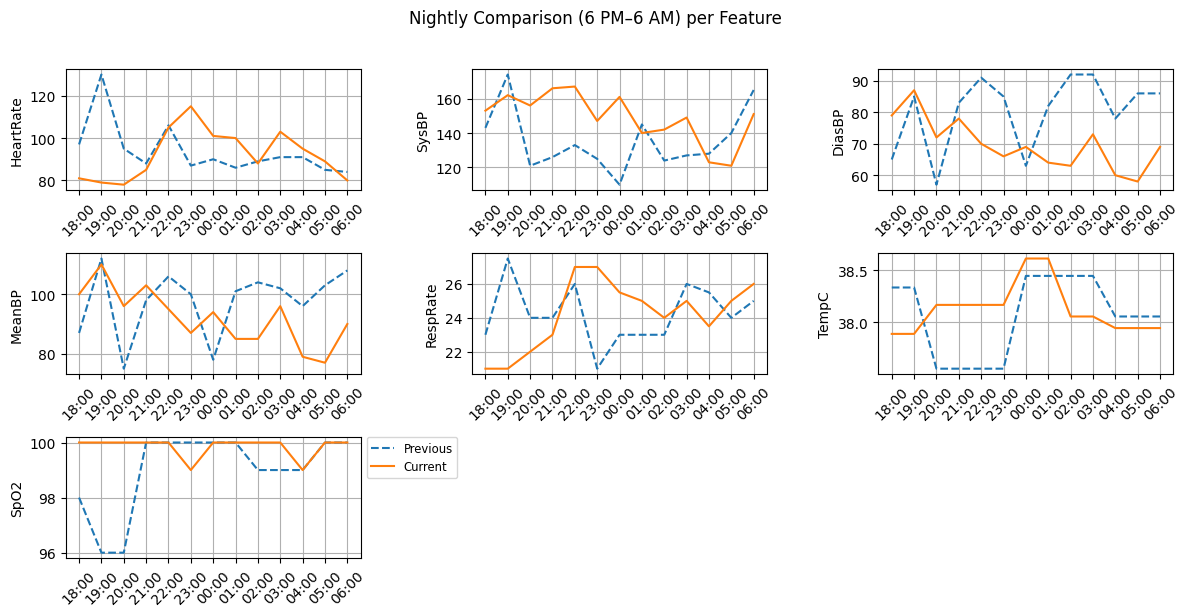

In [30]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_two_nights_features_subplots(
    sample_prev: np.ndarray,
    sample_curr: np.ndarray,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    在每个子图中对比前一夜和当夜同一特征的时序：
    - sample_prev、sample_curr：形状均为 (T, F) 的数组
    - feature_names：长度为 F 的特征名列表
    - start_hour：开始小时（如 18 表示 18:00）
    - ncols：子图每行列数
    - title_prefix：整体标题前缀

    返回两个 DataFrame (df_prev, df_curr)，方便后续检查。
    """
    # 校验输入
    T, F = sample_curr.shape
    assert sample_prev.shape == sample_curr.shape, "两个样本的形状必须相同 (T, F)"

    # 构造时间标签
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # 构造 DataFrame
    df_prev = pd.DataFrame(sample_prev, columns=feature_names, index=hour_labels)
    df_curr = pd.DataFrame(sample_curr, columns=feature_names, index=hour_labels)

    # 子图布局
    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, feature in enumerate(feature_names):
        ax = axes_flat[idx]
        # 绘制前一夜（虚线）和当夜（实线）
        ax.plot(range(T), df_prev[feature], label="Previous", linestyle="--")
        ax.plot(range(T), df_curr[feature], label="Current",   linestyle="-")
        ax.set_ylabel(feature)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)
        ax.grid(True)

    ax.legend(
        ["Previous", "Current"],
        loc="upper left",
        fontsize="small",
        # bbox_to_anchor 的第一个参数 >1 表示在轴外右侧
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return df_prev, df_curr

# usage sample
idx = 2
sample_prev = NightAndDelta_dataset_Continuous.iloc[idx]['PreviousNight']
sample_curr = NightAndDelta_dataset_Continuous.iloc[idx]['CurrentNight']
df_prev, df_curr = plot_two_nights_features_subplots(
    sample_prev, sample_curr, feature_names,
    start_hour=18, ncols=3,
    title_prefix="Nightly Comparison (6 PM–6 AM)"
)


# STAGE2: time-series augmentation

*  Transfer Learning Training model (freeze encoders), only trian on classification head



In [32]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def fit_minmax_scaler(train_X: np.ndarray, eps: float = 0.05) -> MinMaxScaler:
    """
    Fit a MinMaxScaler to training data only.

    Parameters
    ----------
    train_X : np.ndarray
        Training data of shape (N, T, F).
    eps : float
        Lower bound of the scaled range. Default is 0.05.

    Returns
    -------
    scaler : MinMaxScaler
        Fitted scaler object.
    """
    _, _, F = train_X.shape
    train_flat = train_X.reshape(-1, F)
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    scaler.fit(train_flat)
    return scaler

def normalize_with_scaler(X: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """
    Normalize input data using a fitted MinMaxScaler.

    Supports both (N, T, F) and (T, F) shaped arrays.

    Parameters
    ----------
    X : np.ndarray
        Input array with shape (N, T, F) or (T, F).
    scaler : MinMaxScaler
        Previously fitted scaler.

    Returns
    -------
    X_norm : np.ndarray
        Normalized array with same shape as input.
    """
    original_shape = X.shape
    if X.ndim == 3:
        N, T, F = X.shape
        flat = X.reshape(-1, F)
        flat_norm = scaler.transform(flat)
        return flat_norm.reshape(N, T, F)
    elif X.ndim == 2:
        T, F = X.shape
        flat_norm = scaler.transform(X)
        return flat_norm.reshape(T, F)
    else:
        raise ValueError("Input must have shape (N, T, F) or (T, F).")


def denormalize_with_scaler(X_norm: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """
    Inverse-transform normalized data using a fitted MinMaxScaler.

    Supports both (N, T, F) and (T, F) shaped arrays.

    Parameters
    ----------
    X_norm : np.ndarray
        Normalized array of shape (N, T, F) or (T, F).
    scaler : MinMaxScaler
        Previously fitted scaler.

    Returns
    -------
    X_raw : np.ndarray
        De-normalized array of same shape as input.
    """
    original_shape = X_norm.shape
    if X_norm.ndim == 3:
        N, T, F = X_norm.shape
        flat_norm = X_norm.reshape(-1, F)
        flat_raw = scaler.inverse_transform(flat_norm)
        return flat_raw.reshape(N, T, F)
    elif X_norm.ndim == 2:
        T, F = X_norm.shape
        flat_raw = scaler.inverse_transform(X_norm)
        return flat_raw.reshape(T, F)
    else:
        raise ValueError("Input must have shape (N, T, F) or (T, F).")


In [33]:
import pandas as pd
from sklearn.utils import resample

def oversample_binary_df(df: pd.DataFrame, target_column: str, random_state: int = 66) -> pd.DataFrame:
    """
    Perform oversampling on the minority class to balance a binary classification dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    target_column : str
        Name of the binary label column.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        Balanced dataframe with equal number of samples from each class.
    """
    # Split majority and minority
    df_majority = df[df[target_column] == 0]
    df_minority = df[df[target_column] == 1]

    # Resample
    df_minority_oversampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=random_state
    )

    # Combine and shuffle
    df_balanced = pd.concat([df_majority, df_minority_oversampled])
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return df_balanced


In [34]:
!pip install tsaug

In [35]:
from tsaug import TimeWarp, AddNoise

# X = np.random.randn(100, 10)  # (T=100, F=10)

# aug = (TimeWarp() * 2  # apply twice
#        + Drift(max_drift=(0.5, 0.5))
#        + AddNoise(scale=0.01))

# X_aug = aug.augment(X)


In [93]:
df = NightAndDelta_dataset_Continuous.copy()
count_df = df.groupby('Fold').apply(lambda x: x.Label.value_counts())
count_df['ratio'] = count_df[1] /(count_df[0]+count_df[1])
count_df

/tmp/ipython-input-2146561864.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  count_df = df.groupby('Fold').apply(lambda x: x.Label.value_counts())


Label     0   1     ratio
Fold                     
0      1320  82  0.058488
1      1363  81  0.056094
2      1387  87  0.059023
3      1300  85  0.061372
4      1361  75  0.052228

# Without Pretrain Weights

## Synthetic Minority Over-sampling Technique (SMOTE)

In [101]:
# !pip install imbalanced-learn

In [102]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=1e-3             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 100
PATIENCE_ES  = 20

BATCH_SIZE = 64


=== Fold 0 ===
Before SMOTE Y Count 5411 328
After SMOTE Y Count 5411 5411
(10822, 13, 7) (10822, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
170/170 - 41s - 241ms/step - loss: 3.2665 - roc_auc: 0.6058 - sensitivity: 0.5962 - specificity: 0.5579 - val_loss: 2.4676 - val_roc_auc: 0.4518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/100
170/170 - 13s - 74ms/step - loss: 1.5597 - roc_auc: 0.6858 - sensitivity: 0.6842 - specificity: 0.5916 - val_loss: 1.3662 - val_roc_auc: 0.5915 - val_sensitivity: 0.9826 - val_specificity: 0.0136
Epoch 3/100
170/170 - 13s - 75ms/step - loss: 1.0026 - roc_auc: 0.7352 - sensitivity: 0.7291 - specificity: 0.6291 - val_loss: 1.1317 - val_roc_auc: 0.5231 - val_sensitivity: 0.3189 - val_specificity: 0.6871
Epoch 4/100
170/170 - 12s - 72ms/step - loss: 0.8199 - roc_auc: 0.7770 - sensitivity: 0.7446 - specificity: 0.6703 - val_loss: 1.0945 - val_roc_auc: 0.5436 - val_sensitivity: 0.1523 - val_specificity: 0.8697
Epoch 5/100
170/170 - 12s - 73ms/step - loss: 0.7437 - roc_auc: 0.7965 - sensitivity: 0.7522 - specificity: 0.7080 - val_loss: 1.0429 - val_roc_auc: 0.5554 - 

Metric       Value
0   True Negatives  962.000000
1  False Positives  358.000000
2  False Negatives   57.000000
3   True Positives   25.000000
4      Sensitivity    0.304878
5      Specificity    0.728788
6        Precision    0.065274
7         F1 Score    0.107527
8           PR AUC    0.063662
9          ROC AUC    0.555488


=== Fold 1 ===
Before SMOTE Y Count 5368 329
After SMOTE Y Count 5368 5368
(10736, 13, 7) (10736, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
168/168 - 38s - 227ms/step - loss: 3.4720 - roc_auc: 0.5880 - sensitivity: 0.5788 - specificity: 0.5516 - val_loss: 2.7854 - val_roc_auc: 0.5769 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/100
168/168 - 12s - 71ms/step - loss: 1.7558 - roc_auc: 0.6549 - sensitivity: 0.6395 - specificity: 0.5859 - val_loss: 1.5242 - val_roc_auc: 0.5127 - val_sensitivity: 1.0000 - val_specificity: 0.0271
Epoch 3/100
168/168 - 12s - 71ms/step - loss: 1.1024 - roc_auc: 0.7149 - sensitivity: 0.6908 - specificity: 0.6243 - val_loss: 1.1235 - val_roc_auc: 0.5429 - val_sensitivity: 0.5994 - val_specificity: 0.4710
Epoch 4/100
168/168 - 12s - 71ms/step - loss: 0.8679 - roc_auc: 0.7639 - sensitivity: 0.7353 - specificity: 0.6652 - val_loss: 1.3613 - val_roc_auc: 0.5623 - val_sensitivity: 0.0492 - val_specificity: 0.9773
Epoch 5/100
168/168 - 12s - 72ms/step - loss: 0.7655 - roc_auc: 0.7941 - sensitivity: 0.7541 - specificity: 0.7031 - val_loss: 1.3328 - val_roc_auc: 0.5773 - 

Metric        Value
0   True Negatives  1182.000000
1  False Positives   181.000000
2  False Negatives    65.000000
3   True Positives    16.000000
4      Sensitivity     0.197531
5      Specificity     0.867205
6        Precision     0.081218
7         F1 Score     0.115108
8           PR AUC     0.065213
9          ROC AUC     0.555773


=== Fold 2 ===
Before SMOTE Y Count 5344 323
After SMOTE Y Count 5344 5344
(10688, 13, 7) (10688, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
167/167 - 32s - 194ms/step - loss: 3.4825 - roc_auc: 0.5973 - sensitivity: 0.5951 - specificity: 0.5530 - val_loss: 2.4997 - val_roc_auc: 0.5964 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/100
167/167 - 10s - 62ms/step - loss: 1.7878 - roc_auc: 0.6631 - sensitivity: 0.6753 - specificity: 0.5735 - val_loss: 1.4385 - val_roc_auc: 0.5924 - val_sensitivity: 0.9640 - val_specificity: 0.0490
Epoch 3/100
167/167 - 11s - 63ms/step - loss: 1.1109 - roc_auc: 0.7217 - sensitivity: 0.7238 - specificity: 0.6082 - val_loss: 1.2421 - val_roc_auc: 0.5219 - val_sensitivity: 0.8810 - val_specificity: 0.1182
Epoch 4/100
167/167 - 11s - 64ms/step - loss: 0.8715 - roc_auc: 0.7693 - sensitivity: 0.7493 - specificity: 0.6538 - val_loss: 1.1497 - val_roc_auc: 0.5556 - val_sensitivity: 0.4578 - val_specificity: 0.6063
Epoch 5/100
167/167 - 11s - 64ms/step - loss: 0.7734 - roc_auc: 0.7895 - sensitivity: 0.7515 - specificity: 0.6824 - val_loss: 1.2215 - val_roc_auc: 0.5501 - 

Metric       Value
0   True Negatives  958.000000
1  False Positives  429.000000
2  False Negatives   47.000000
3   True Positives   40.000000
4      Sensitivity    0.459770
5      Specificity    0.690699
6        Precision    0.085288
7         F1 Score    0.143885
8           PR AUC    0.068232
9          ROC AUC    0.568630


=== Fold 3 ===
Before SMOTE Y Count 5431 325
After SMOTE Y Count 5431 5431
(10862, 13, 7) (10862, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
170/170 - 38s - 224ms/step - loss: 3.3074 - roc_auc: 0.6002 - sensitivity: 0.5782 - specificity: 0.5717 - val_loss: 2.2736 - val_roc_auc: 0.4140 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/100
170/170 - 12s - 70ms/step - loss: 1.6131 - roc_auc: 0.6562 - sensitivity: 0.6492 - specificity: 0.5804 - val_loss: 1.2717 - val_roc_auc: 0.5330 - val_sensitivity: 0.7223 - val_specificity: 0.3408
Epoch 3/100
170/170 - 11s - 67ms/step - loss: 1.0302 - roc_auc: 0.7067 - sensitivity: 0.6967 - specificity: 0.6091 - val_loss: 1.2180 - val_roc_auc: 0.5672 - val_sensitivity: 0.0085 - val_specificity: 0.9638
Epoch 4/100
170/170 - 11s - 67ms/step - loss: 0.8508 - roc_auc: 0.7419 - sensitivity: 0.7303 - specificity: 0.6317 - val_loss: 1.4182 - val_roc_auc: 0.5662 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9962
Epoch 5/100
170/170 - 12s - 68ms/step - loss: 0.7687 - roc_auc: 0.7684 - sensitivity: 0.7350 - specificity: 0.6704 - val_loss: 1.4878 - val_roc_auc: 0.474

Metric       Value
0   True Negatives  889.000000
1  False Positives  411.000000
2  False Negatives   49.000000
3   True Positives   36.000000
4      Sensitivity    0.423529
5      Specificity    0.683846
6        Precision    0.080537
7         F1 Score    0.135338
8           PR AUC    0.082521
9          ROC AUC    0.585367


=== Fold 4 ===
Before SMOTE Y Count 5370 335
After SMOTE Y Count 5370 5370
(10740, 13, 7) (10740, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
168/168 - 38s - 228ms/step - loss: 3.3795 - roc_auc: 0.6039 - sensitivity: 0.5927 - specificity: 0.5570 - val_loss: 2.8463 - val_roc_auc: 0.4818 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/100
168/168 - 12s - 71ms/step - loss: 1.6885 - roc_auc: 0.6798 - sensitivity: 0.6585 - specificity: 0.6063 - val_loss: 1.7004 - val_roc_auc: 0.4939 - val_sensitivity: 0.9838 - val_specificity: 0.0228
Epoch 3/100
168/168 - 12s - 72ms/step - loss: 1.0732 - roc_auc: 0.7285 - sensitivity: 0.7117 - specificity: 0.6352 - val_loss: 1.3613 - val_roc_auc: 0.5227 - val_sensitivity: 0.0191 - val_specificity: 0.9735
Epoch 4/100
168/168 - 12s - 72ms/step - loss: 0.8610 - roc_auc: 0.7627 - sensitivity: 0.7250 - specificity: 0.6795 - val_loss: 1.2446 - val_roc_auc: 0.5064 - val_sensitivity: 0.3027 - val_specificity: 0.7149
Epoch 5/100
168/168 - 12s - 72ms/step - loss: 0.7633 - roc_auc: 0.7886 - sensitivity: 0.7365 - specificity: 0.7004 - val_loss: 0.9423 - val_roc_auc: 0.5853 - 

Metric       Value
0   True Negatives  977.000000
1  False Positives  384.000000
2  False Negatives   46.000000
3   True Positives   29.000000
4      Sensitivity    0.386667
5      Specificity    0.717855
6        Precision    0.070218
7         F1 Score    0.118852
8           PR AUC    0.058641
9          ROC AUC    0.569434

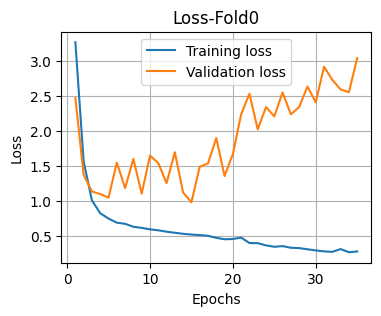

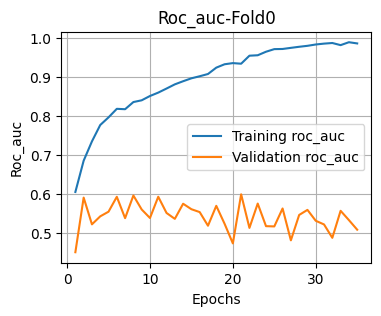

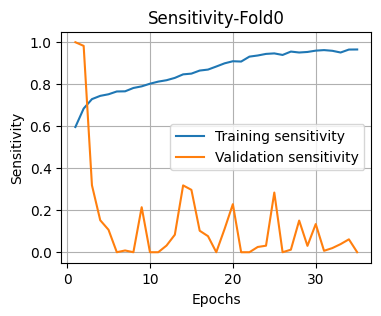

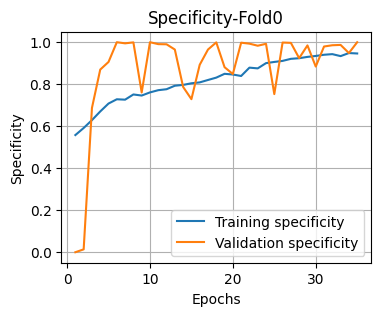

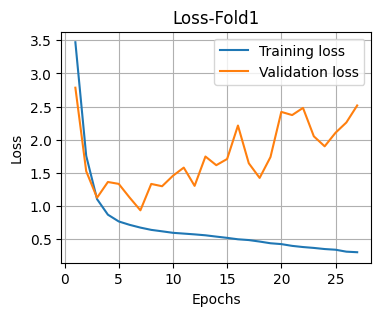

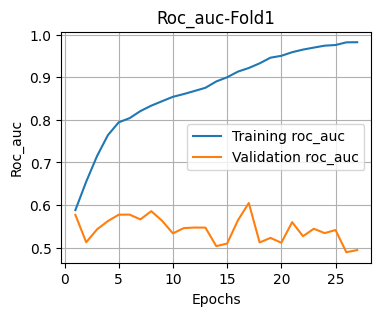

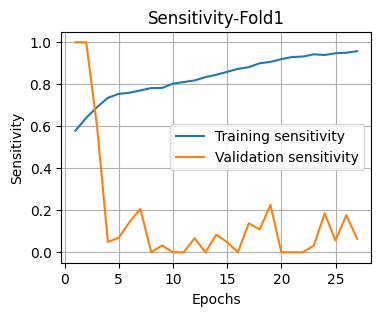

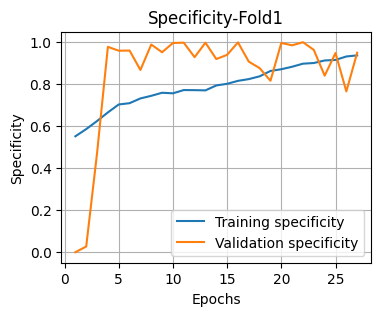

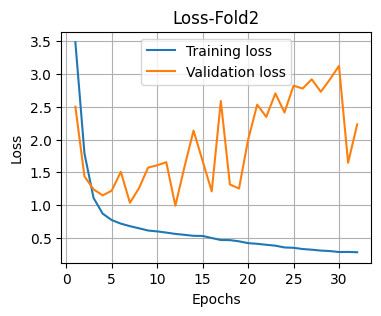

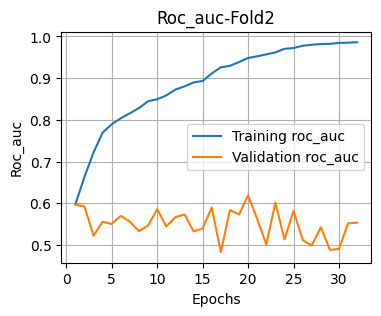

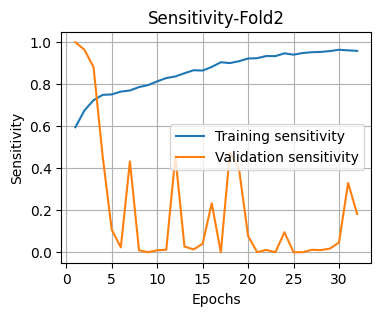

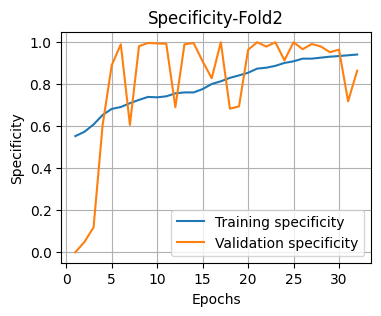

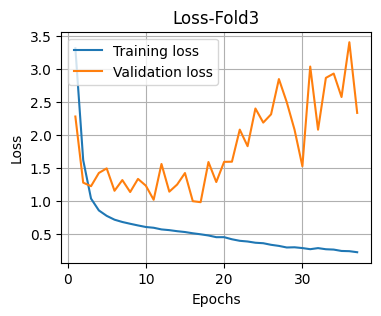

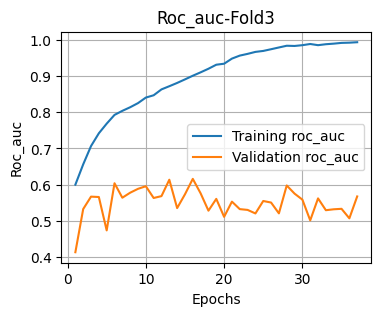

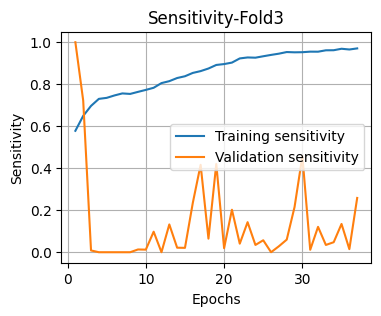

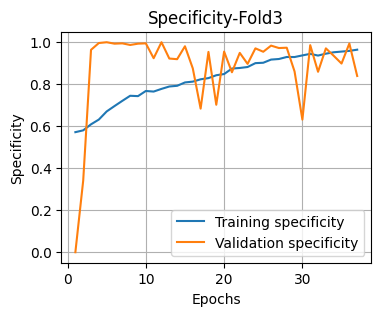

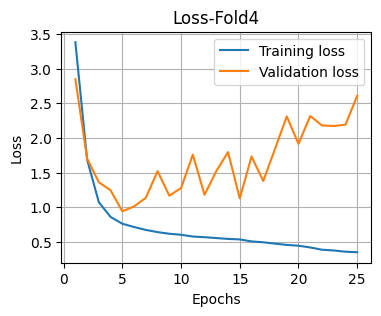

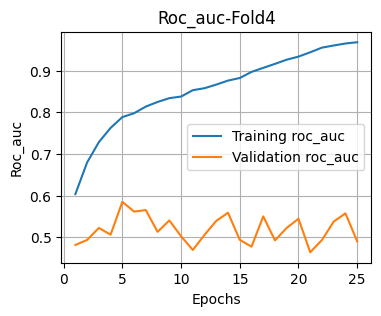

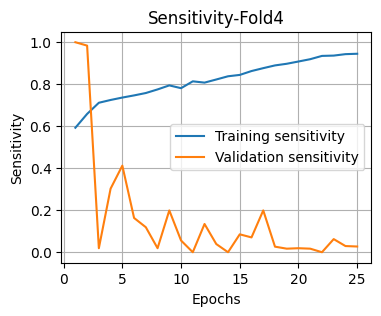

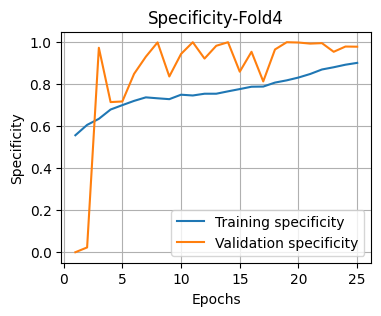

In [103]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    # Extract X
    X_train_nor, X_train_delta_nor = np.stack(train_df["Nor_X"].to_numpy()), np.stack(train_df['Nor_delta'])
    # Extract y
    y_train = train_df["Label"].to_numpy(dtype=np.int32)
    # Y_train = to_categorical(train_df["Label"].to_numpy(dtype=np.int32), num_classes=2)

    # Apply SMOT
    sm = SMOTE(random_state=42)
    n, t, f = X_train_nor.shape
    X_cat = np.concatenate([X_train_nor, X_train_delta_nor], axis=2) #(n, t, 2f)
    X_flat = X_cat.reshape((n, t*f*2)) #(n*t, 2f)
    X_res, y_train_smote = sm.fit_resample(X_flat, y_train)
    X_res_cat = X_res.reshape(X_res.shape[0], t, 2 * f)
    X_train_smote, X_train_delta_smote = X_res_cat[:, :, :f], X_res_cat[:,:, f:]
    print("Before SMOTE Y Count", np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1))
    print("After SMOTE Y Count", np.count_nonzero(y_train_smote == 0), np.count_nonzero(y_train_smote == 1))
    print(X_train_smote.shape, X_train_delta_smote.shape)
    Y_train_smote = to_categorical(y_train_smote, num_classes=2)

    # For Val apply oversampling
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier with Random Init
    input_shape_li = (X_test_nor.shape[1:], X_delta_test_nor.shape[1:])
    encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
    classification_model = classification_2encoder(input_shape_li,
                                                   encoders,
                                                   freeze_encoders=False,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_smote, X_train_delta_smote], # two inputs
                                       Y_train_smote,
                                       validation_data=(
                                           [X_val_nor_os, X_val_delta_nor_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # break

In [104]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0   962  358  57  25     0.304878     0.728788   0.065274  0.107527  0.063662   
1  1182  181  65  16     0.197531     0.867205   0.081218  0.115108  0.065213   
2   958  429  47  40     0.459770     0.690699   0.085288  0.143885  0.068232   
3   889  411  49  36     0.423529     0.683846   0.080537  0.135338  0.082521   
4   977  384  46  29     0.386667     0.717855   0.070218  0.118852  0.058641   

    ROC_auc  
0  0.555488  
1  0.555773  
2  0.568630  
3  0.585367  
4  0.569434


Mean ± std across folds:


tn        fp       fn       tp  sensitivity  specificity  \
0      962.000  358.0000  57.0000  25.0000     0.304878     0.728788   
1     1182.000  181.0000  65.0000  16.0000     0.197531     0.867205   
2      958.000  429.0000  47.0000  40.0000     0.459770     0.690699   
3      889.000  411.0000  49.0000  36.0000     0.423529     0.683846   
4      977.000  384.0000  46.0000  29.0000     0.386667     0.717855   
mean   993.600  352.6000  52.8000  29.2000     0.354500     0.737700   
std    110.654   99.6358   8.0747   9.4181     0.104900     0.074800   

      precision  f1_score    PR_auc   ROC_auc  
0      0.065274  0.107527  0.063662  0.555488  
1      0.081218  0.115108  0.065213  0.555773  
2      0.085288  0.143885  0.068232  0.568630  
3      0.080537  0.135338  0.082521  0.585367  
4      0.070218  0.118852  0.058641  0.569434  
mean   0.076500  0.124100  0.067700  0.566900  
std    0.008400  0.015000  0.009000  0.012300

## TimeWarp-2

In [111]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=1e-3             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 20
PATIENCE_ES  = 20

BATCH_SIZE = 64


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
170/170 - 38s - 221ms/step - loss: 3.6220 - roc_auc: 0.5536 - sensitivity: 0.5483 - specificity: 0.5437 - val_loss: 2.5464 - val_roc_auc: 0.5077 - val_sensitivity: 0.0061 - val_specificity: 0.9939
Epoch 2/100
170/170 - 12s - 68ms/step - loss: 1.9223 - roc_auc: 0.5861 - sensitivity: 0.5640 - specificity: 0.5554 - val_loss: 1.5917 - val_roc_auc: 0.4578 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9977
Epoch 3/100
170/170 - 11s - 67ms/step - loss: 1.2136 - roc_auc: 0.6173 - sensitivity: 0.6228 - specificity: 0.5474 - val_loss: 1.3575 - val_roc_auc: 0.4291 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9970
Epoch 4/100
170/170 - 12s - 68ms/step - loss: 0.9667 - roc_auc: 0.6291 - sensitivity: 0.6276 - specificity: 0.5480 - val_loss: 1.1367 - val_roc_auc: 0.5303 - val_sensitivity: 0.1644 - val_specificity: 0.8758
Epoch 5/100
170/170 - 12s - 70ms/step - loss: 0.8670 - roc_auc: 0.6374 - sensitivity: 0.6709 - specificity: 0.5241 - val_loss: 0.9858 - val_roc_auc: 0.557

Metric        Value
0   True Negatives   227.000000
1  False Positives  1093.000000
2  False Negatives    10.000000
3   True Positives    72.000000
4      Sensitivity     0.878049
5      Specificity     0.171970
6        Precision     0.061803
7         F1 Score     0.115477
8           PR AUC     0.067641
9          ROC AUC     0.538405


=== Fold 1 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
168/168 - 38s - 226ms/step - loss: 3.3507 - roc_auc: 0.5482 - sensitivity: 0.5384 - specificity: 0.5276 - val_loss: 2.1723 - val_roc_auc: 0.5848 - val_sensitivity: 0.8269 - val_specificity: 0.2986
Epoch 2/100
168/168 - 12s - 69ms/step - loss: 1.6318 - roc_auc: 0.5770 - sensitivity: 0.5762 - specificity: 0.5384 - val_loss: 1.2629 - val_roc_auc: 0.5253 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/100
168/168 - 12s - 69ms/step - loss: 1.0689 - roc_auc: 0.5914 - sensitivity: 0.5713 - specificity: 0.5484 - val_loss: 1.0320 - val_roc_auc: 0.6066 - val_sensitivity: 0.0081 - val_specificity: 0.9831
Epoch 4/100
168/168 - 11s - 68ms/step - loss: 0.8983 - roc_auc: 0.6150 - sensitivity: 0.6451 - specificity: 0.5170 - val_loss: 1.0104 - val_roc_auc: 0.5894 - val_sensitivity: 0.0961 - val_specificity: 0.9318
Epoch 5/100
168/168 - 11s - 67ms/step - loss: 0.8305 - roc_auc: 0.6352 - sensitivity: 0.6721 - specificity: 0.5287 - val_loss: 0.8183 - val_roc_auc: 0.6085 - 

Metric        Value
0   True Negatives    65.000000
1  False Positives  1298.000000
2  False Negatives     3.000000
3   True Positives    78.000000
4      Sensitivity     0.962963
5      Specificity     0.047689
6        Precision     0.056686
7         F1 Score     0.107069
8           PR AUC     0.067472
9          ROC AUC     0.541924


=== Fold 2 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
167/167 - 31s - 189ms/step - loss: 3.7361 - roc_auc: 0.5571 - sensitivity: 0.5423 - specificity: 0.5399 - val_loss: 2.6125 - val_roc_auc: 0.5850 - val_sensitivity: 0.9171 - val_specificity: 0.1384
Epoch 2/100
167/167 - 10s - 62ms/step - loss: 2.0375 - roc_auc: 0.5947 - sensitivity: 0.5762 - specificity: 0.5531 - val_loss: 1.6195 - val_roc_auc: 0.6288 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/100
167/167 - 10s - 61ms/step - loss: 1.2870 - roc_auc: 0.6180 - sensitivity: 0.6033 - specificity: 0.5565 - val_loss: 1.2313 - val_roc_auc: 0.5577 - val_sensitivity: 0.0115 - val_specificity: 0.9870
Epoch 4/100
167/167 - 10s - 60ms/step - loss: 0.9951 - roc_auc: 0.6373 - sensitivity: 0.6441 - specificity: 0.5509 - val_loss: 0.9720 - val_roc_auc: 0.6093 - val_sensitivity: 0.6431 - val_specificity: 0.5191
Epoch 5/100
167/167 - 10s - 60ms/step - loss: 0.8803 - roc_auc: 0.6463 - sensitivity: 0.6766 - specificity: 0.5365 - val_loss: 0.9259 - val_roc_auc: 0.5377 - 

Metric       Value
0   True Negatives  536.000000
1  False Positives  851.000000
2  False Negatives   16.000000
3   True Positives   71.000000
4      Sensitivity    0.816092
5      Specificity    0.386446
6        Precision    0.077007
7         F1 Score    0.140733
8           PR AUC    0.082694
9          ROC AUC    0.633212


=== Fold 3 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
170/170 - 37s - 217ms/step - loss: 3.5091 - roc_auc: 0.5463 - sensitivity: 0.5338 - specificity: 0.5360 - val_loss: 2.5221 - val_roc_auc: 0.4104 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
170/170 - 11s - 66ms/step - loss: 1.7888 - roc_auc: 0.5652 - sensitivity: 0.5314 - specificity: 0.5516 - val_loss: 1.4480 - val_roc_auc: 0.4214 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/100
170/170 - 11s - 67ms/step - loss: 1.1321 - roc_auc: 0.6001 - sensitivity: 0.5712 - specificity: 0.5653 - val_loss: 1.0599 - val_roc_auc: 0.4594 - val_sensitivity: 0.0546 - val_specificity: 0.9154
Epoch 4/100
170/170 - 12s - 69ms/step - loss: 0.9263 - roc_auc: 0.6133 - sensitivity: 0.6043 - specificity: 0.5546 - val_loss: 0.9021 - val_roc_auc: 0.5454 - val_sensitivity: 0.3869 - val_specificity: 0.6431
Epoch 5/100
170/170 - 12s - 68ms/step - loss: 0.8411 - roc_auc: 0.6351 - sensitivity: 0.6270 - specificity: 0.5625 - val_loss: 0.8708 - val_roc_auc: 0.561

Metric        Value
0   True Negatives   112.000000
1  False Positives  1188.000000
2  False Negatives     5.000000
3   True Positives    80.000000
4      Sensitivity     0.941176
5      Specificity     0.086154
6        Precision     0.063091
7         F1 Score     0.118256
8           PR AUC     0.081429
9          ROC AUC     0.611502


=== Fold 4 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
168/168 - 38s - 223ms/step - loss: 3.4763 - roc_auc: 0.5427 - sensitivity: 0.5309 - specificity: 0.5315 - val_loss: 2.4274 - val_roc_auc: 0.5153 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
168/168 - 12s - 72ms/step - loss: 1.7434 - roc_auc: 0.5863 - sensitivity: 0.5899 - specificity: 0.5313 - val_loss: 1.4181 - val_roc_auc: 0.5222 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/100
168/168 - 12s - 71ms/step - loss: 1.1082 - roc_auc: 0.6252 - sensitivity: 0.6207 - specificity: 0.5650 - val_loss: 1.0787 - val_roc_auc: 0.5472 - val_sensitivity: 0.0147 - val_specificity: 0.9978
Epoch 4/100
168/168 - 12s - 69ms/step - loss: 0.9127 - roc_auc: 0.6388 - sensitivity: 0.6613 - specificity: 0.5523 - val_loss: 1.0141 - val_roc_auc: 0.5326 - val_sensitivity: 0.0874 - val_specificity: 0.9295
Epoch 5/100
168/168 - 12s - 70ms/step - loss: 0.8366 - roc_auc: 0.6517 - sensitivity: 0.6667 - specificity: 0.5696 - val_loss: 1.0702 - val_roc_auc: 0.523

Metric        Value
0   True Negatives   156.000000
1  False Positives  1205.000000
2  False Negatives     4.000000
3   True Positives    71.000000
4      Sensitivity     0.946667
5      Specificity     0.114622
6        Precision     0.055643
7         F1 Score     0.105107
8           PR AUC     0.055820
9          ROC AUC     0.525569

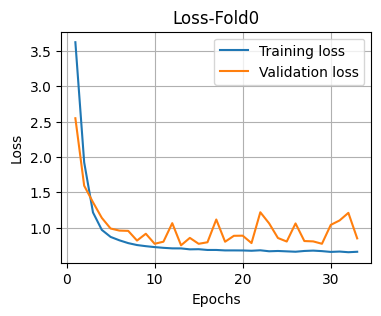

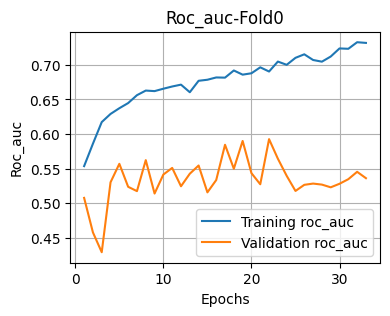

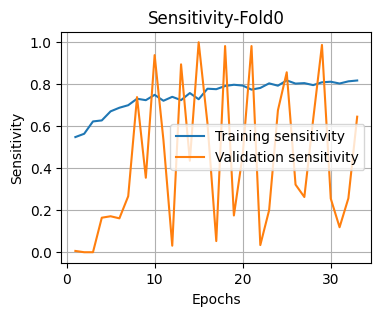

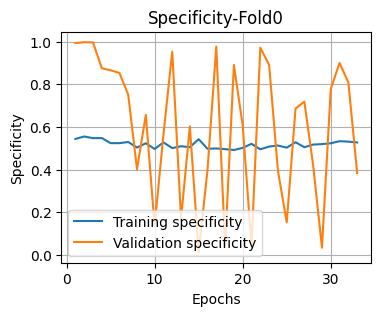

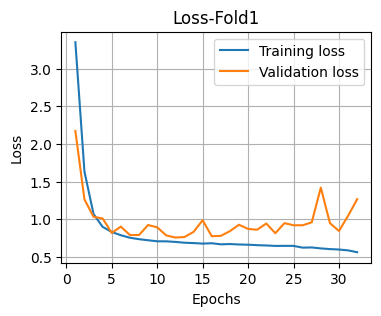

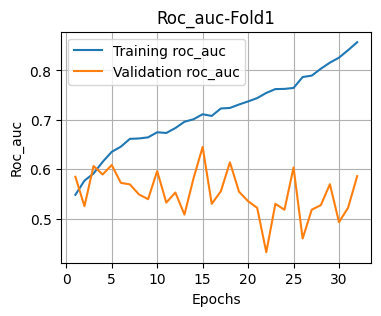

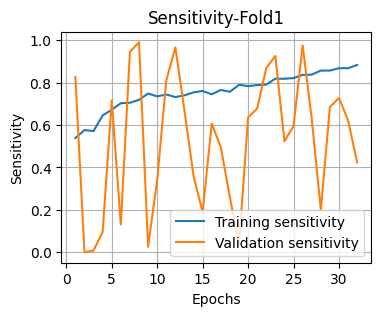

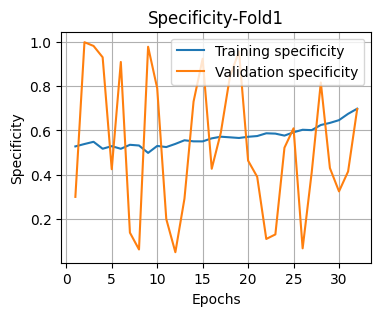

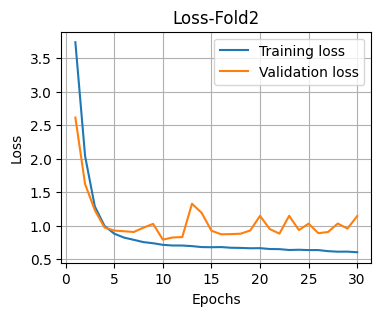

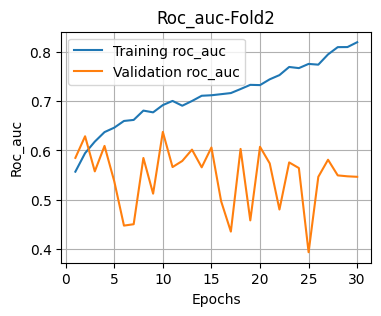

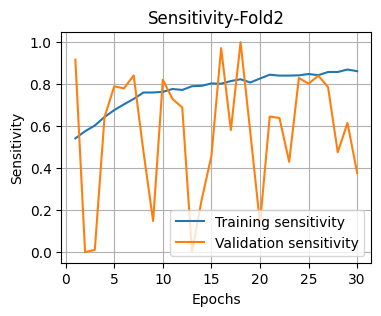

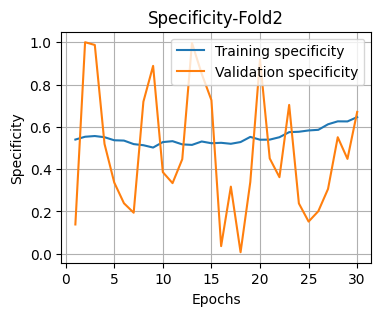

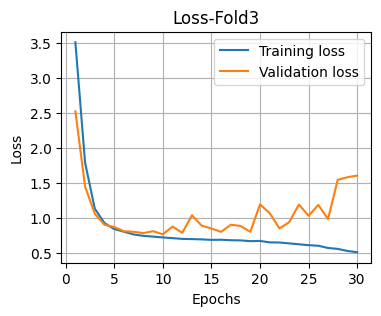

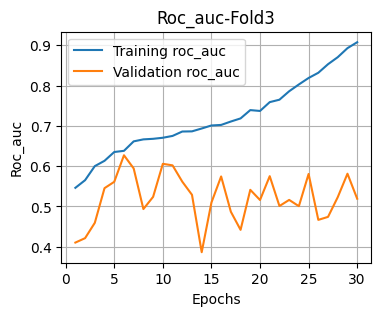

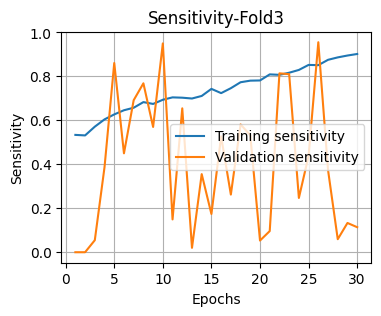

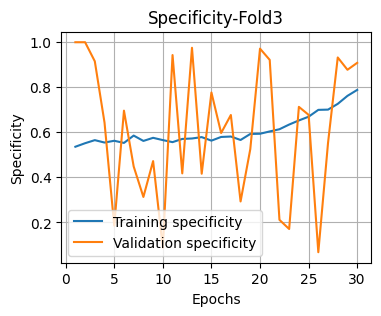

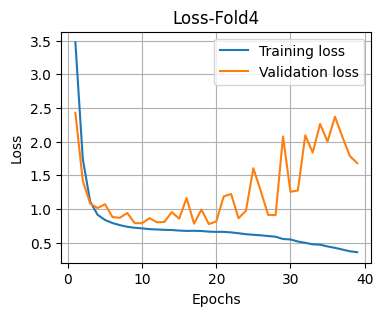

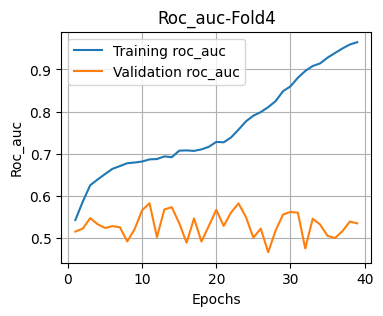

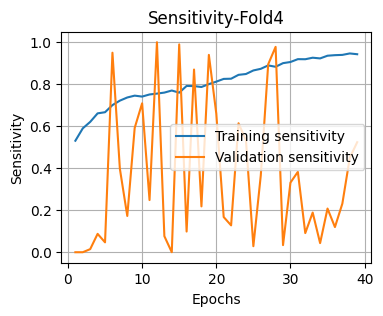

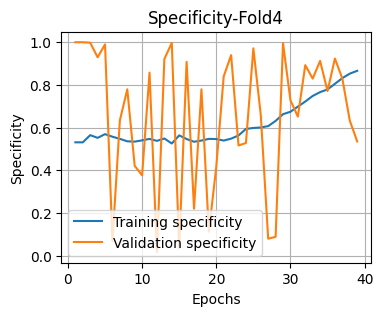

In [112]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    # Extract X
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])

    #  Augment
    aug = TimeWarp(n_speed_change=2, max_speed_ratio=2)
    X_train_aug_os = aug.augment(X_train_nor_os)
    X_val_aug_os   = aug.augment(X_val_nor_os)

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_test_nor.shape[1:], X_delta_test_nor.shape[1:])
    encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
    classification_model = classification_2encoder(input_shape_li,
                                                   encoders,
                                                   freeze_encoders=False,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_nor_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_nor_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # break

In [113]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn    fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  227  1093  10  72     0.878049     0.171970   0.061803  0.115477  0.067641   
1   65  1298   3  78     0.962963     0.047689   0.056686  0.107069  0.067472   
2  536   851  16  71     0.816092     0.386446   0.077007  0.140733  0.082694   
3  112  1188   5  80     0.941176     0.086154   0.063091  0.118256  0.081429   
4  156  1205   4  71     0.946667     0.114622   0.055643  0.105107  0.055820   

    ROC_auc  
0  0.538405  
1  0.541924  
2  0.633212  
3  0.611502  
4  0.525569


Mean ± std across folds:


tn         fp       fn       tp  sensitivity  specificity  \
0     227.0000  1093.0000  10.0000  72.0000     0.878049     0.171970   
1      65.0000  1298.0000   3.0000  78.0000     0.962963     0.047689   
2     536.0000   851.0000  16.0000  71.0000     0.816092     0.386446   
3     112.0000  1188.0000   5.0000  80.0000     0.941176     0.086154   
4     156.0000  1205.0000   4.0000  71.0000     0.946667     0.114622   
mean  219.2000  1127.0000   7.6000  74.4000     0.909000     0.161400   
std   186.8735   170.5711   5.4129   4.2778     0.061100     0.133700   

      precision  f1_score    PR_auc   ROC_auc  
0      0.061803  0.115477  0.067641  0.538405  
1      0.056686  0.107069  0.067472  0.541924  
2      0.077007  0.140733  0.082694  0.633212  
3      0.063091  0.118256  0.081429  0.611502  
4      0.055643  0.105107  0.055820  0.525569  
mean   0.062800  0.117300  0.071000  0.570100  
std    0.008500  0.014200  0.011200  0.048700

## AddNoise

In [108]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 100
PATIENCE_ES  = 20

BATCH_SIZE = 64


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
170/170 - 38s - 225ms/step - loss: 3.9919 - roc_auc: 0.5490 - sensitivity: 0.5354 - specificity: 0.5284 - val_loss: 3.2661 - val_roc_auc: 0.5192 - val_sensitivity: 0.9765 - val_specificity: 0.0242
Epoch 2/100
170/170 - 12s - 71ms/step - loss: 2.8529 - roc_auc: 0.5922 - sensitivity: 0.5753 - specificity: 0.5517 - val_loss: 2.3753 - val_roc_auc: 0.5473 - val_sensitivity: 0.7394 - val_specificity: 0.3106
Epoch 3/100
170/170 - 12s - 70ms/step - loss: 2.0433 - roc_auc: 0.6162 - sensitivity: 0.6152 - specificity: 0.5554 - val_loss: 1.7718 - val_roc_auc: 0.5453 - val_sensitivity: 0.4477 - val_specificity: 0.5871
Epoch 4/100
170/170 - 12s - 68ms/step - loss: 1.5270 - roc_auc: 0.6341 - sensitivity: 0.6252 - specificity: 0.5672 - val_loss: 1.5391 - val_roc_auc: 0.5305 - val_sensitivity: 0.0780 - val_specificity: 0.9402
Epoch 5/100
170/170 - 12s - 69ms/step - loss: 1.2197 - roc_auc: 0.6469 - sensitivity: 0.6489 - specificity: 0.5587 - val_loss: 1.2806 - val_roc_auc: 0.5423 - val_

Metric        Value
0   True Negatives   184.000000
1  False Positives  1136.000000
2  False Negatives     9.000000
3   True Positives    73.000000
4      Sensitivity     0.890244
5      Specificity     0.139394
6        Precision     0.060380
7         F1 Score     0.113091
8           PR AUC     0.087345
9          ROC AUC     0.592341


=== Fold 1 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
168/168 - 37s - 223ms/step - loss: 3.9415 - roc_auc: 0.5587 - sensitivity: 0.5428 - specificity: 0.5434 - val_loss: 3.3116 - val_roc_auc: 0.5515 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
168/168 - 12s - 70ms/step - loss: 2.7762 - roc_auc: 0.5945 - sensitivity: 0.5654 - specificity: 0.5633 - val_loss: 2.5087 - val_roc_auc: 0.5972 - val_sensitivity: 0.0081 - val_specificity: 0.9978
Epoch 3/100
168/168 - 12s - 69ms/step - loss: 1.9733 - roc_auc: 0.6108 - sensitivity: 0.5836 - specificity: 0.5779 - val_loss: 1.7401 - val_roc_auc: 0.5458 - val_sensitivity: 0.2128 - val_specificity: 0.8335
Epoch 4/100
168/168 - 11s - 68ms/step - loss: 1.4684 - roc_auc: 0.6384 - sensitivity: 0.6064 - specificity: 0.5848 - val_loss: 1.3137 - val_roc_auc: 0.6007 - val_sensitivity: 0.6449 - val_specificity: 0.5620
Epoch 5/100
168/168 - 12s - 71ms/step - loss: 1.1762 - roc_auc: 0.6601 - sensitivity: 0.6485 - specificity: 0.5835 - val_loss: 1.2175 - val_roc_auc: 0.5126 - 

Metric        Value
0   True Negatives   296.000000
1  False Positives  1067.000000
2  False Negatives    11.000000
3   True Positives    70.000000
4      Sensitivity     0.864198
5      Specificity     0.217168
6        Precision     0.061566
7         F1 Score     0.114943
8           PR AUC     0.070536
9          ROC AUC     0.594558


=== Fold 2 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
167/167 - 32s - 194ms/step - loss: 3.9820 - roc_auc: 0.5602 - sensitivity: 0.5453 - specificity: 0.5447 - val_loss: 3.4082 - val_roc_auc: 0.4386 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
167/167 - 11s - 64ms/step - loss: 2.8409 - roc_auc: 0.5896 - sensitivity: 0.5597 - specificity: 0.5627 - val_loss: 2.4464 - val_roc_auc: 0.5060 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/100
167/167 - 10s - 60ms/step - loss: 2.0418 - roc_auc: 0.6047 - sensitivity: 0.5807 - specificity: 0.5651 - val_loss: 1.8395 - val_roc_auc: 0.5077 - val_sensitivity: 0.0887 - val_specificity: 0.9344
Epoch 4/100
167/167 - 11s - 64ms/step - loss: 1.5163 - roc_auc: 0.6294 - sensitivity: 0.6201 - specificity: 0.5556 - val_loss: 1.5225 - val_roc_auc: 0.5525 - val_sensitivity: 0.3468 - val_specificity: 0.7578
Epoch 5/100
167/167 - 11s - 65ms/step - loss: 1.2100 - roc_auc: 0.6496 - sensitivity: 0.6607 - specificity: 0.5520 - val_loss: 1.3385 - val_roc_auc: 0.566

Metric       Value
0   True Negatives  558.000000
1  False Positives  829.000000
2  False Negatives   24.000000
3   True Positives   63.000000
4      Sensitivity    0.724138
5      Specificity    0.402307
6        Precision    0.070628
7         F1 Score    0.128703
8           PR AUC    0.081245
9          ROC AUC    0.595464


=== Fold 3 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
170/170 - 37s - 218ms/step - loss: 4.1366 - roc_auc: 0.5425 - sensitivity: 0.5178 - specificity: 0.5369 - val_loss: 3.4837 - val_roc_auc: 0.5811 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
170/170 - 12s - 68ms/step - loss: 3.0146 - roc_auc: 0.5625 - sensitivity: 0.5410 - specificity: 0.5539 - val_loss: 2.5939 - val_roc_auc: 0.5801 - val_sensitivity: 0.0123 - val_specificity: 0.9915
Epoch 3/100
170/170 - 12s - 69ms/step - loss: 2.1932 - roc_auc: 0.5959 - sensitivity: 0.5651 - specificity: 0.5728 - val_loss: 1.8769 - val_roc_auc: 0.5741 - val_sensitivity: 0.2569 - val_specificity: 0.8054
Epoch 4/100
170/170 - 12s - 68ms/step - loss: 1.6512 - roc_auc: 0.6102 - sensitivity: 0.5870 - specificity: 0.5629 - val_loss: 1.5662 - val_roc_auc: 0.4997 - val_sensitivity: 0.2862 - val_specificity: 0.7454
Epoch 5/100
170/170 - 12s - 68ms/step - loss: 1.3083 - roc_auc: 0.6340 - sensitivity: 0.6457 - specificity: 0.5480 - val_loss: 1.2619 - val_roc_auc: 0.5311 - 

Metric       Value
0   True Negatives  484.000000
1  False Positives  816.000000
2  False Negatives   26.000000
3   True Positives   59.000000
4      Sensitivity    0.694118
5      Specificity    0.372308
6        Precision    0.067429
7         F1 Score    0.122917
8           PR AUC    0.060274
9          ROC AUC    0.517982


=== Fold 4 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ night_encoder[1]… │
│ (Concatenate)       │                   │            │ delta_encoder[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 633,410 (2.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

None
Epoch 1/100
168/168 - 37s - 221ms/step - loss: 3.9664 - roc_auc: 0.5542 - sensitivity: 0.5367 - specificity: 0.5412 - val_loss: 3.7848 - val_roc_auc: 0.5006 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
168/168 - 12s - 69ms/step - loss: 2.7852 - roc_auc: 0.5804 - sensitivity: 0.5462 - specificity: 0.5676 - val_loss: 2.4992 - val_roc_auc: 0.5278 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/100
168/168 - 12s - 70ms/step - loss: 1.9660 - roc_auc: 0.6129 - sensitivity: 0.5864 - specificity: 0.5669 - val_loss: 1.8881 - val_roc_auc: 0.5831 - val_sensitivity: 0.0125 - val_specificity: 0.9934
Epoch 4/100
168/168 - 12s - 70ms/step - loss: 1.4683 - roc_auc: 0.6332 - sensitivity: 0.5981 - specificity: 0.5914 - val_loss: 1.4269 - val_roc_auc: 0.5421 - val_sensitivity: 0.1293 - val_specificity: 0.9037
Epoch 5/100
168/168 - 12s - 69ms/step - loss: 1.1780 - roc_auc: 0.6495 - sensitivity: 0.6194 - specificity: 0.5950 - val_loss: 1.1974 - val_roc_auc: 0.560

Metric        Value
0   True Negatives   164.000000
1  False Positives  1197.000000
2  False Negatives     4.000000
3   True Positives    71.000000
4      Sensitivity     0.946667
5      Specificity     0.120500
6        Precision     0.055994
7         F1 Score     0.105733
8           PR AUC     0.047459
9          ROC AUC     0.491345

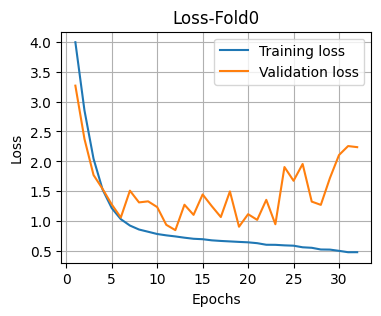

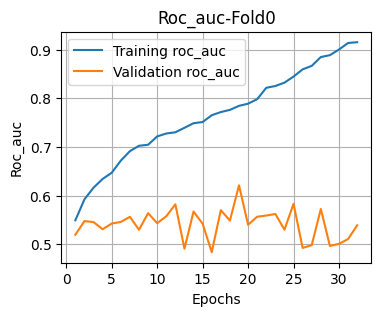

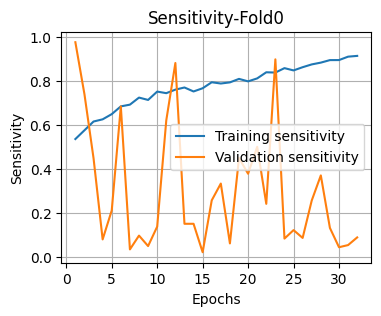

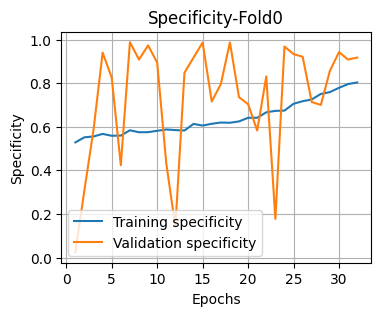

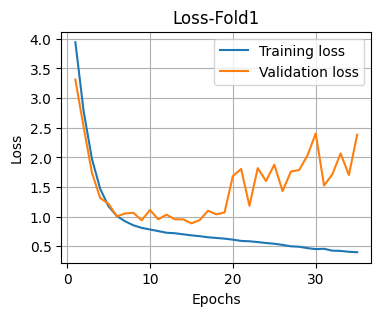

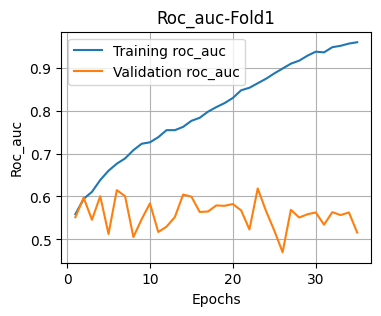

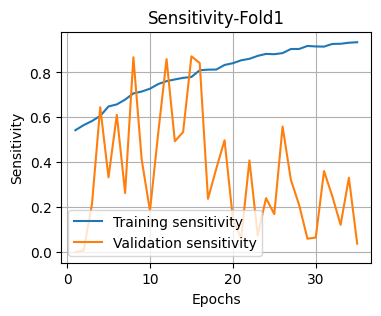

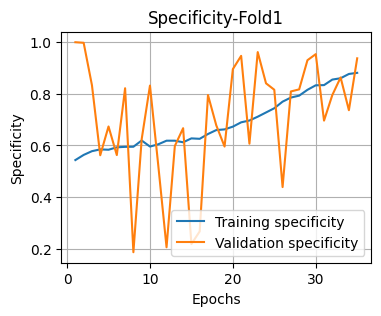

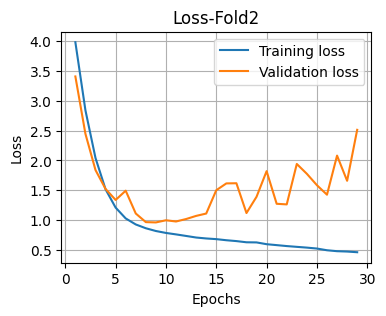

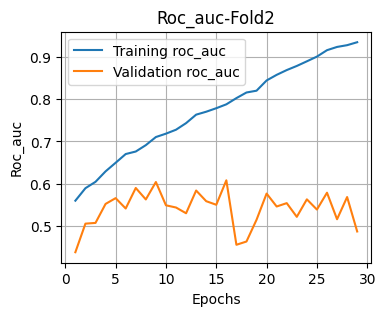

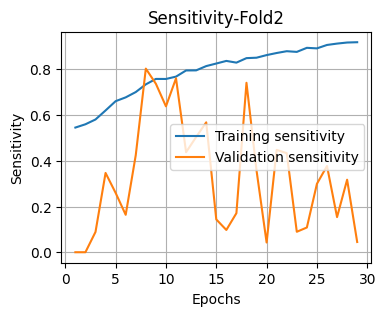

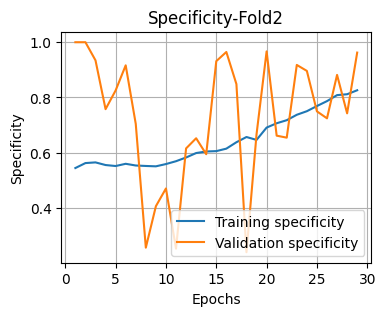

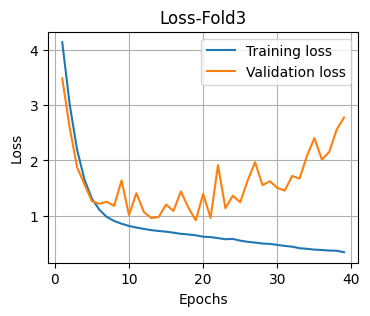

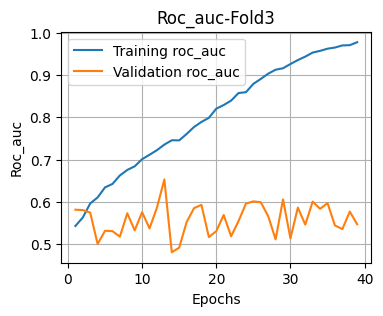

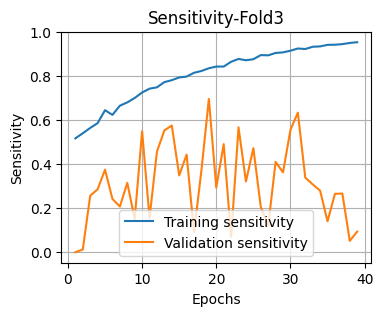

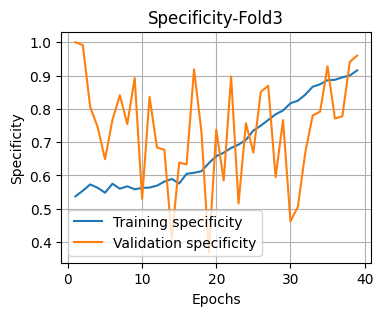

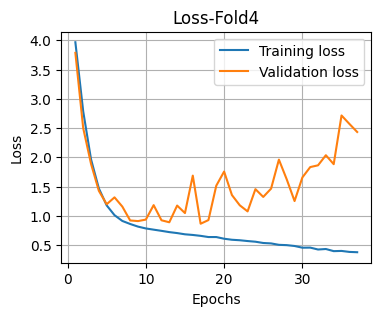

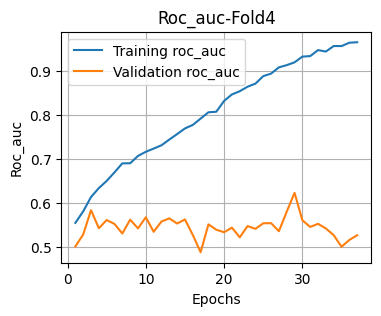

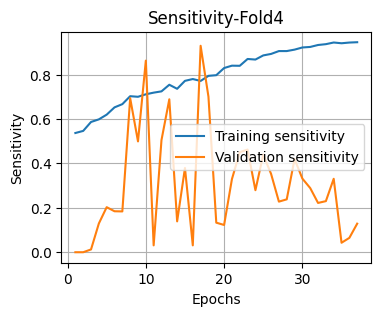

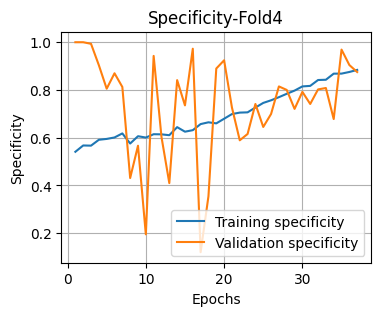

In [109]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    # Extract X
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])

    #  Augment
    aug = AddNoise(scale=0.05)
    X_train_aug_os = aug.augment(X_train_nor_os)
    X_val_aug_os   = aug.augment(X_val_nor_os)

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_test_nor.shape[1:], X_delta_test_nor.shape[1:])
    encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
    classification_model = classification_2encoder(input_shape_li,
                                                   encoders,
                                                   freeze_encoders=False,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_nor_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_nor_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # break

In [110]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn    fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  184  1136   9  73     0.890244     0.139394   0.060380  0.113091  0.087345   
1  296  1067  11  70     0.864198     0.217168   0.061566  0.114943  0.070536   
2  558   829  24  63     0.724138     0.402307   0.070628  0.128703  0.081245   
3  484   816  26  59     0.694118     0.372308   0.067429  0.122917  0.060274   
4  164  1197   4  71     0.946667     0.120500   0.055994  0.105733  0.047459   

    ROC_auc  
0  0.592341  
1  0.594558  
2  0.595464  
3  0.517982  
4  0.491345


Mean ± std across folds:


tn         fp       fn      tp  sensitivity  specificity  \
0     184.0000  1136.0000   9.0000  73.000     0.890244     0.139394   
1     296.0000  1067.0000  11.0000  70.000     0.864198     0.217168   
2     558.0000   829.0000  24.0000  63.000     0.724138     0.402307   
3     484.0000   816.0000  26.0000  59.000     0.694118     0.372308   
4     164.0000  1197.0000   4.0000  71.000     0.946667     0.120500   
mean  337.2000  1009.0000  14.8000  67.200     0.823900     0.250300   
std   177.1079   176.4129   9.6799   5.933     0.109400     0.130600   

      precision  f1_score    PR_auc   ROC_auc  
0      0.060380  0.113091  0.087345  0.592341  
1      0.061566  0.114943  0.070536  0.594558  
2      0.070628  0.128703  0.081245  0.595464  
3      0.067429  0.122917  0.060274  0.517982  
4      0.055994  0.105733  0.047459  0.491345  
mean   0.063200  0.117100  0.069400  0.558300  
std    0.005800  0.008900  0.016000  0.049900

# With Pretrain Weights

In [31]:
model_name = 'GRUMAE_nontruma_Jul28_1500'

# Load pretrained encoders
encoders, _ = load_models(os.path.join(MODEL_FOLDER, model_name), load_autoencoder=False)
# Save a snapshot of the initial weights
raw_init_w   = encoders[0].get_weights()
delta_init_w = encoders[1].get_weights()

Encoders loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1500


## Synthetic Minority Over-sampling Technique (SMOTE)

In [54]:
!pip install imbalanced-learn

In [94]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 100
PATIENCE_ES  = 20

BATCH_SIZE = 64


=== Fold 0 ===
Before SMOTE Y Count 5411 328
After SMOTE Y Count 5411 5411
(10822, 13, 7) (10822, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
170/170 - 21s - 126ms/step - loss: 0.9196 - roc_auc: 0.6035 - sensitivity: 0.5818 - specificity: 0.5653 - val_loss: 0.8131 - val_roc_auc: 0.5637 - val_sensitivity: 0.3076 - val_specificity: 0.7409
Epoch 2/100
170/170 - 6s - 32ms/step - loss: 0.7003 - roc_auc: 0.6834 - sensitivity: 0.6359 - specificity: 0.6276 - val_loss: 0.8058 - val_roc_auc: 0.5676 - val_sensitivity: 0.4348 - val_specificity: 0.6848
Epoch 3/100
170/170 - 5s - 31ms/step - loss: 0.6424 - roc_auc: 0.7305 - sensitivity: 0.6829 - specificity: 0.6603 - val_loss: 0.8232 - val_roc_auc: 0.5836 - val_sensitivity: 0.3803 - val_specificity: 0.7250
Epoch 4/100
170/170 - 5s - 31ms/step - loss: 0.6031 - roc_auc: 0.7692 - sensitivity: 0.7119 - specificity: 0.6967 - val_loss: 0.8320 - val_roc_auc: 0.5875 - val_sensitivity: 0.3886 - val_specificity: 0.7242
Epoch 5/100
170/170 - 6s - 33ms/step - loss: 0.5861 - roc_auc: 0.7839 - sensitivity: 0.7248 - specificity: 0.7062 - val_loss: 0.8382 - val_roc_auc: 0.5883 - val_sens

Metric       Value
0   True Negatives  904.000000
1  False Positives  416.000000
2  False Negatives   46.000000
3   True Positives   36.000000
4      Sensitivity    0.439024
5      Specificity    0.684848
6        Precision    0.079646
7         F1 Score    0.134831
8           PR AUC    0.075406
9          ROC AUC    0.571794


=== Fold 1 ===
Before SMOTE Y Count 5368 329
After SMOTE Y Count 5368 5368
(10736, 13, 7) (10736, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
168/168 - 22s - 129ms/step - loss: 0.9532 - roc_auc: 0.5804 - sensitivity: 0.5684 - specificity: 0.5551 - val_loss: 0.7386 - val_roc_auc: 0.5725 - val_sensitivity: 0.4211 - val_specificity: 0.6310
Epoch 2/100
168/168 - 5s - 32ms/step - loss: 0.7132 - roc_auc: 0.6679 - sensitivity: 0.6233 - specificity: 0.6157 - val_loss: 0.7207 - val_roc_auc: 0.5945 - val_sensitivity: 0.5701 - val_specificity: 0.5503
Epoch 3/100
168/168 - 6s - 33ms/step - loss: 0.6542 - roc_auc: 0.7147 - sensitivity: 0.6682 - specificity: 0.6392 - val_loss: 0.7339 - val_roc_auc: 0.5924 - val_sensitivity: 0.5202 - val_specificity: 0.6038
Epoch 4/100
168/168 - 6s - 36ms/step - loss: 0.6188 - roc_auc: 0.7509 - sensitivity: 0.7012 - specificity: 0.6673 - val_loss: 0.7540 - val_roc_auc: 0.5934 - val_sensitivity: 0.4703 - val_specificity: 0.6368
Epoch 5/100
168/168 - 5s - 32ms/step - loss: 0.5874 - roc_auc: 0.7804 - sensitivity: 0.7187 - specificity: 0.6943 - val_loss: 0.8019 - val_roc_auc: 0.5848 - val_sens

Metric       Value
0   True Negatives  750.000000
1  False Positives  613.000000
2  False Negatives   35.000000
3   True Positives   46.000000
4      Sensitivity    0.567901
5      Specificity    0.550257
6        Precision    0.069803
7         F1 Score    0.124324
8           PR AUC    0.075125
9          ROC AUC    0.600418


=== Fold 2 ===
Before SMOTE Y Count 5344 323
After SMOTE Y Count 5344 5344
(10688, 13, 7) (10688, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
167/167 - 17s - 104ms/step - loss: 0.9448 - roc_auc: 0.5943 - sensitivity: 0.5928 - specificity: 0.5513 - val_loss: 0.7844 - val_roc_auc: 0.5420 - val_sensitivity: 0.5299 - val_specificity: 0.5371
Epoch 2/100
167/167 - 4s - 26ms/step - loss: 0.7097 - roc_auc: 0.6713 - sensitivity: 0.6400 - specificity: 0.6057 - val_loss: 0.7723 - val_roc_auc: 0.5654 - val_sensitivity: 0.5436 - val_specificity: 0.5797
Epoch 3/100
167/167 - 5s - 30ms/step - loss: 0.6608 - roc_auc: 0.7075 - sensitivity: 0.6710 - specificity: 0.6394 - val_loss: 0.7578 - val_roc_auc: 0.5798 - val_sensitivity: 0.5660 - val_specificity: 0.5977
Epoch 4/100
167/167 - 5s - 27ms/step - loss: 0.6224 - roc_auc: 0.7457 - sensitivity: 0.7079 - specificity: 0.6615 - val_loss: 0.7877 - val_roc_auc: 0.5833 - val_sensitivity: 0.5508 - val_specificity: 0.6265
Epoch 5/100
167/167 - 5s - 28ms/step - loss: 0.6036 - roc_auc: 0.7677 - sensitivity: 0.7324 - specificity: 0.6826 - val_loss: 0.7993 - val_roc_auc: 0.5876 - val_sens

Metric       Value
0   True Negatives  829.000000
1  False Positives  558.000000
2  False Negatives   39.000000
3   True Positives   48.000000
4      Sensitivity    0.551724
5      Specificity    0.597693
6        Precision    0.079208
7         F1 Score    0.138528
8           PR AUC    0.083164
9          ROC AUC    0.576378


=== Fold 3 ===
Before SMOTE Y Count 5431 325
After SMOTE Y Count 5431 5431
(10862, 13, 7) (10862, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
170/170 - 22s - 127ms/step - loss: 0.9051 - roc_auc: 0.5815 - sensitivity: 0.5745 - specificity: 0.5485 - val_loss: 0.7173 - val_roc_auc: 0.6112 - val_sensitivity: 0.4908 - val_specificity: 0.6192
Epoch 2/100
170/170 - 5s - 31ms/step - loss: 0.7012 - roc_auc: 0.6704 - sensitivity: 0.6351 - specificity: 0.6085 - val_loss: 0.7299 - val_roc_auc: 0.6094 - val_sensitivity: 0.4562 - val_specificity: 0.6700
Epoch 3/100
170/170 - 5s - 32ms/step - loss: 0.6283 - roc_auc: 0.7393 - sensitivity: 0.6938 - specificity: 0.6586 - val_loss: 0.7645 - val_roc_auc: 0.6021 - val_sensitivity: 0.4677 - val_specificity: 0.6631
Epoch 4/100
170/170 - 5s - 31ms/step - loss: 0.5890 - roc_auc: 0.7803 - sensitivity: 0.7301 - specificity: 0.6920 - val_loss: 0.8106 - val_roc_auc: 0.5917 - val_sensitivity: 0.4623 - val_specificity: 0.6692
Epoch 5/100
170/170 - 5s - 31ms/step - loss: 0.5761 - roc_auc: 0.7938 - sensitivity: 0.7487 - specificity: 0.6991 - val_loss: 0.8230 - val_roc_auc: 0.5968 - val_sens

Metric       Value
0   True Negatives  805.000000
1  False Positives  495.000000
2  False Negatives   43.000000
3   True Positives   42.000000
4      Sensitivity    0.494118
5      Specificity    0.619231
6        Precision    0.078212
7         F1 Score    0.135048
8           PR AUC    0.089127
9          ROC AUC    0.600326


=== Fold 4 ===
Before SMOTE Y Count 5370 335
After SMOTE Y Count 5370 5370
(10740, 13, 7) (10740, 13, 7)


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
168/168 - 21s - 126ms/step - loss: 0.8985 - roc_auc: 0.5898 - sensitivity: 0.5696 - specificity: 0.5635 - val_loss: 0.7933 - val_roc_auc: 0.5215 - val_sensitivity: 0.4137 - val_specificity: 0.6150
Epoch 2/100
168/168 - 5s - 31ms/step - loss: 0.7067 - roc_auc: 0.6759 - sensitivity: 0.6387 - specificity: 0.6235 - val_loss: 0.7838 - val_roc_auc: 0.5296 - val_sensitivity: 0.4100 - val_specificity: 0.6245
Epoch 3/100
168/168 - 5s - 31ms/step - loss: 0.6386 - roc_auc: 0.7301 - sensitivity: 0.6812 - specificity: 0.6588 - val_loss: 0.8054 - val_roc_auc: 0.5379 - val_sensitivity: 0.3799 - val_specificity: 0.6774
Epoch 4/100
168/168 - 5s - 30ms/step - loss: 0.6011 - roc_auc: 0.7691 - sensitivity: 0.7134 - specificity: 0.6896 - val_loss: 0.8182 - val_roc_auc: 0.5465 - val_sensitivity: 0.3813 - val_specificity: 0.6679
Epoch 5/100
168/168 - 5s - 32ms/step - loss: 0.5843 - roc_auc: 0.7859 - sensitivity: 0.7292 - specificity: 0.7054 - val_loss: 0.8249 - val_roc_auc: 0.5477 - val_sens

Metric       Value
0   True Negatives  850.000000
1  False Positives  511.000000
2  False Negatives   48.000000
3   True Positives   27.000000
4      Sensitivity    0.360000
5      Specificity    0.624541
6        Precision    0.050186
7         F1 Score    0.088091
8           PR AUC    0.051792
9          ROC AUC    0.512408

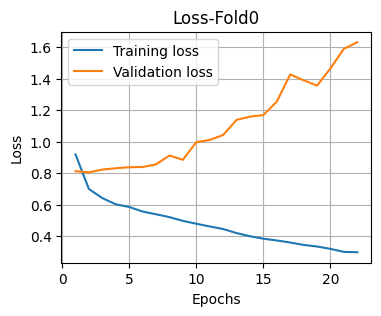

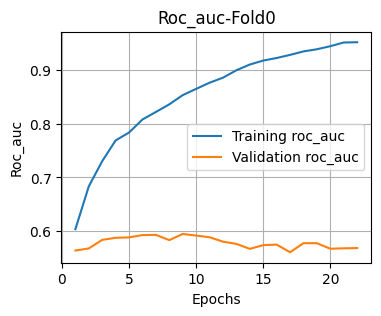

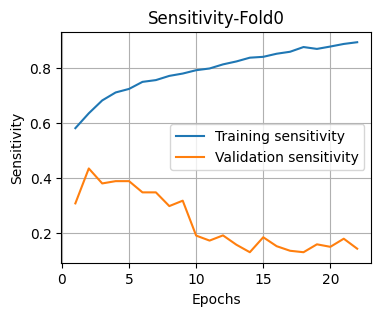

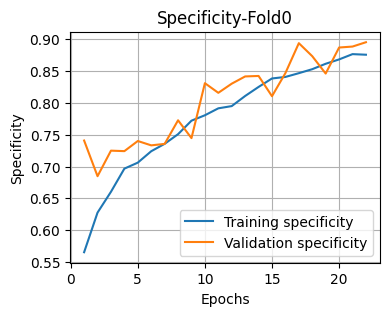

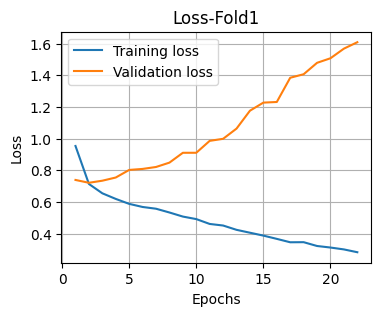

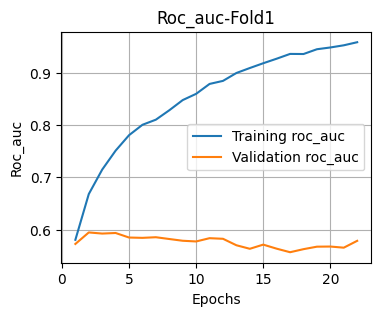

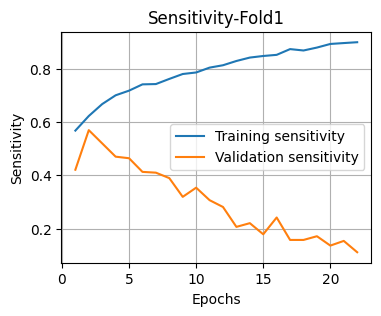

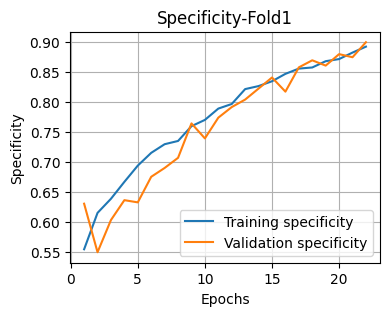

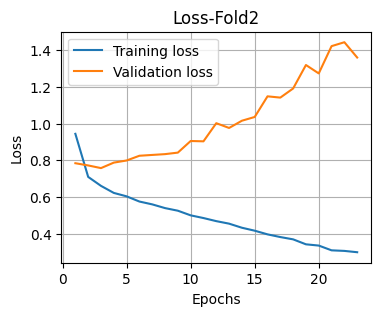

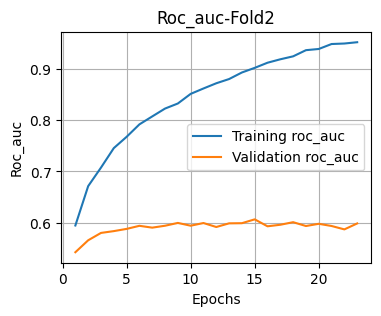

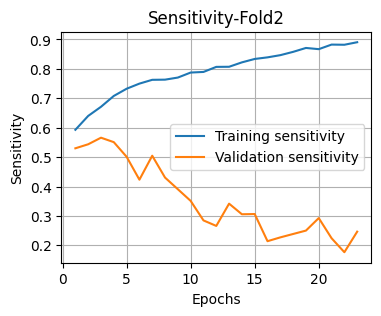

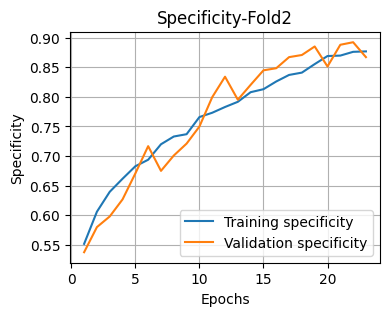

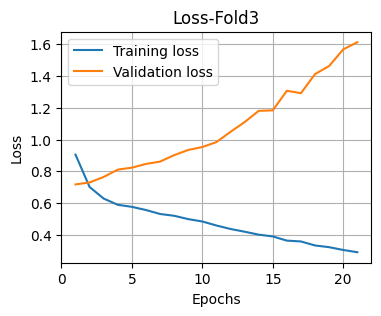

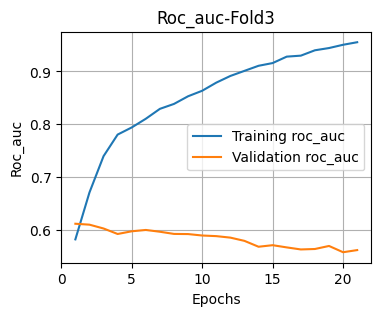

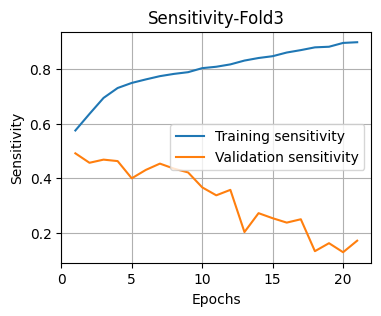

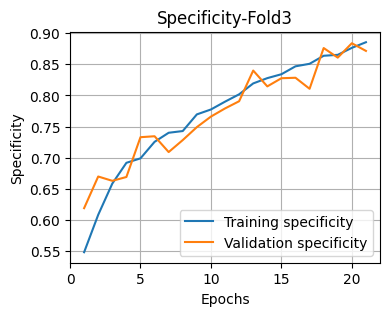

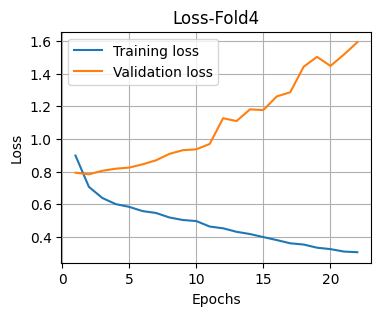

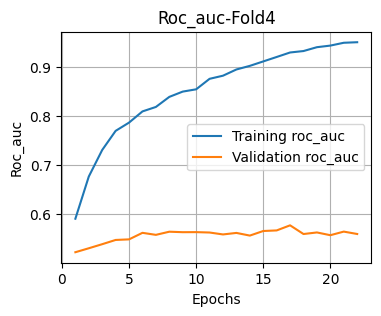

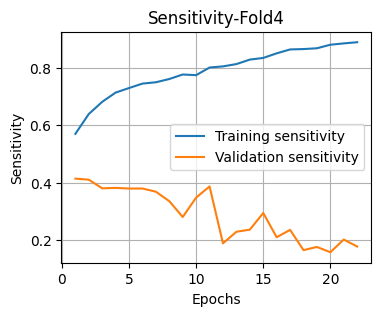

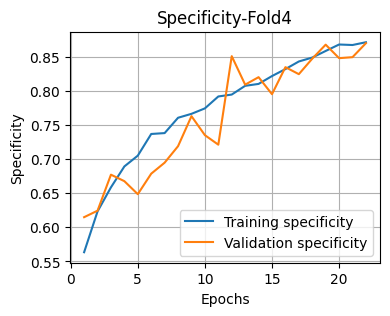

In [98]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    # Extract X
    X_train_nor, X_train_delta_nor = np.stack(train_df["Nor_X"].to_numpy()), np.stack(train_df['Nor_delta'])
    # Extract y
    y_train = train_df["Label"].to_numpy(dtype=np.int32)
    # Y_train = to_categorical(train_df["Label"].to_numpy(dtype=np.int32), num_classes=2)

    # Apply SMOT
    sm = SMOTE(random_state=42)
    n, t, f = X_train_nor.shape
    X_cat = np.concatenate([X_train_nor, X_train_delta_nor], axis=2) #(n, t, 2f)
    X_flat = X_cat.reshape((n, t*f*2)) #(n*t, 2f)
    X_res, y_train_smote = sm.fit_resample(X_flat, y_train)
    X_res_cat = X_res.reshape(X_res.shape[0], t, 2 * f)
    X_train_smote, X_train_delta_smote = X_res_cat[:, :, :f], X_res_cat[:,:, f:]
    print("Before SMOTE Y Count", np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1))
    print("After SMOTE Y Count", np.count_nonzero(y_train_smote == 0), np.count_nonzero(y_train_smote == 1))
    print(X_train_smote.shape, X_train_delta_smote.shape)
    Y_train_smote = to_categorical(y_train_smote, num_classes=2)

    # For Val apply oversampling
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_test_nor.shape[1:], X_delta_test_nor.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_smote, X_train_delta_smote], # two inputs
                                       Y_train_smote,
                                       validation_data=(
                                           [X_val_nor_os, X_val_delta_nor_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # break

In [89]:
# num_of_smapling =  neg / pos  (Fold0)
5411/328

16.496951219512194

In [99]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  904  416  46  36     0.439024     0.684848   0.079646  0.134831  0.075406   
1  750  613  35  46     0.567901     0.550257   0.069803  0.124324  0.075125   
2  829  558  39  48     0.551724     0.597693   0.079208  0.138528  0.083164   
3  805  495  43  42     0.494118     0.619231   0.078212  0.135048  0.089127   
4  850  511  48  27     0.360000     0.624541   0.050186  0.088091  0.051792   

    ROC_auc  
0  0.571794  
1  0.600418  
2  0.576378  
3  0.600326  
4  0.512408


Mean ± std across folds:


tn        fp       fn       tp  sensitivity  specificity  \
0     904.0000  416.0000  46.0000  36.0000     0.439024     0.684848   
1     750.0000  613.0000  35.0000  46.0000     0.567901     0.550257   
2     829.0000  558.0000  39.0000  48.0000     0.551724     0.597693   
3     805.0000  495.0000  43.0000  42.0000     0.494118     0.619231   
4     850.0000  511.0000  48.0000  27.0000     0.360000     0.624541   
mean  827.6000  518.6000  42.2000  39.8000     0.482600     0.615300   
std    56.7301   73.4935   5.2631   8.4971     0.085300     0.048700   

      precision  f1_score    PR_auc   ROC_auc  
0      0.079646  0.134831  0.075406  0.571794  
1      0.069803  0.124324  0.075125  0.600418  
2      0.079208  0.138528  0.083164  0.576378  
3      0.078212  0.135048  0.089127  0.600326  
4      0.050186  0.088091  0.051792  0.512408  
mean   0.071400  0.124200  0.074900  0.572300  
std    0.012500  0.020900  0.014200  0.036000

## TimeWarp

In [48]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 100
PATIENCE_ES  = 20

BATCH_SIZE = 64


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
170/170 - 22s - 132ms/step - loss: 0.9481 - roc_auc: 0.5493 - sensitivity: 0.5387 - specificity: 0.5278 - val_loss: 0.7234 - val_roc_auc: 0.5756 - val_sensitivity: 0.6909 - val_specificity: 0.4174
Epoch 2/100
170/170 - 6s - 33ms/step - loss: 0.7638 - roc_auc: 0.5712 - sensitivity: 0.5515 - specificity: 0.5432 - val_loss: 0.7166 - val_roc_auc: 0.5727 - val_sensitivity: 0.7424 - val_specificity: 0.3136
Epoch 3/100
170/170 - 5s - 32ms/step - loss: 0.7241 - roc_auc: 0.5836 - sensitivity: 0.5829 - specificity: 0.5352 - val_loss: 0.7142 - val_roc_auc: 0.5668 - val_sensitivity: 0.6152 - val_specificity: 0.4765
Epoch 4/100
170/170 - 5s - 31ms/step - loss: 0.7063 - roc_auc: 0.6018 - sensitivity: 0.5884 - specificity: 0.5496 - val_loss: 0.7110 - val_roc_auc: 0.5763 - val_sensitivity: 0.5629 - val_specificity: 0.5311
Epoch 5/100
170/170 - 5s - 31ms/step - loss: 0.6855 - roc_auc: 0.6382 - sensitivity: 0.6208 - specificity: 0.5764 - val_loss: 0.7061 - val_roc_auc: 0.5938 - val_sens

Metric       Value
0   True Negatives  689.000000
1  False Positives  631.000000
2  False Negatives   35.000000
3   True Positives   47.000000
4      Sensitivity    0.573171
5      Specificity    0.521970
6        Precision    0.069322
7         F1 Score    0.123684
8           PR AUC    0.076630
9          ROC AUC    0.577504


=== Fold 1 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
168/168 - 21s - 125ms/step - loss: 0.9950 - roc_auc: 0.5338 - sensitivity: 0.5302 - specificity: 0.5175 - val_loss: 0.7207 - val_roc_auc: 0.5623 - val_sensitivity: 0.4820 - val_specificity: 0.5657
Epoch 2/100
168/168 - 5s - 30ms/step - loss: 0.7819 - roc_auc: 0.5576 - sensitivity: 0.5402 - specificity: 0.5494 - val_loss: 0.7020 - val_roc_auc: 0.6036 - val_sensitivity: 0.5459 - val_specificity: 0.5715
Epoch 3/100
168/168 - 5s - 31ms/step - loss: 0.7222 - roc_auc: 0.5936 - sensitivity: 0.5609 - specificity: 0.5730 - val_loss: 0.7015 - val_roc_auc: 0.6107 - val_sensitivity: 0.6713 - val_specificity: 0.5128
Epoch 4/100
168/168 - 5s - 31ms/step - loss: 0.7050 - roc_auc: 0.6077 - sensitivity: 0.5801 - specificity: 0.5782 - val_loss: 0.7003 - val_roc_auc: 0.6155 - val_sensitivity: 0.6816 - val_specificity: 0.4967
Epoch 5/100
168/168 - 5s - 30ms/step - loss: 0.6931 - roc_auc: 0.6271 - sensitivity: 0.5967 - specificity: 0.5922 - val_loss: 0.6991 - val_roc_auc: 0.6173 - val_sens

Metric       Value
0   True Negatives  812.000000
1  False Positives  551.000000
2  False Negatives   31.000000
3   True Positives   50.000000
4      Sensitivity    0.617284
5      Specificity    0.595745
6        Precision    0.083195
7         F1 Score    0.146628
8           PR AUC    0.077133
9          ROC AUC    0.620708


=== Fold 2 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
167/167 - 18s - 106ms/step - loss: 0.9772 - roc_auc: 0.5283 - sensitivity: 0.5417 - specificity: 0.5036 - val_loss: 0.7362 - val_roc_auc: 0.5468 - val_sensitivity: 0.4989 - val_specificity: 0.5941
Epoch 2/100
167/167 - 5s - 28ms/step - loss: 0.7745 - roc_auc: 0.5579 - sensitivity: 0.5661 - specificity: 0.5152 - val_loss: 0.7183 - val_roc_auc: 0.5602 - val_sensitivity: 0.6200 - val_specificity: 0.4665
Epoch 3/100
167/167 - 5s - 29ms/step - loss: 0.7202 - roc_auc: 0.5889 - sensitivity: 0.5863 - specificity: 0.5417 - val_loss: 0.7209 - val_roc_auc: 0.5609 - val_sensitivity: 0.5299 - val_specificity: 0.5638
Epoch 4/100
167/167 - 4s - 26ms/step - loss: 0.7014 - roc_auc: 0.6107 - sensitivity: 0.5997 - specificity: 0.5503 - val_loss: 0.7196 - val_roc_auc: 0.5632 - val_sensitivity: 0.6950 - val_specificity: 0.4066
Epoch 5/100
167/167 - 4s - 27ms/step - loss: 0.6829 - roc_auc: 0.6403 - sensitivity: 0.6385 - specificity: 0.5687 - val_loss: 0.7229 - val_roc_auc: 0.5694 - val_sens

Metric       Value
0   True Negatives  663.000000
1  False Positives  724.000000
2  False Negatives   31.000000
3   True Positives   56.000000
4      Sensitivity    0.643678
5      Specificity    0.478010
6        Precision    0.071795
7         F1 Score    0.129181
8           PR AUC    0.071105
9          ROC AUC    0.575458


=== Fold 3 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
170/170 - 21s - 126ms/step - loss: 0.9751 - roc_auc: 0.5223 - sensitivity: 0.4907 - specificity: 0.5362 - val_loss: 0.7125 - val_roc_auc: 0.5694 - val_sensitivity: 0.4154 - val_specificity: 0.6562
Epoch 2/100
170/170 - 5s - 31ms/step - loss: 0.7828 - roc_auc: 0.5460 - sensitivity: 0.5159 - specificity: 0.5544 - val_loss: 0.7004 - val_roc_auc: 0.6000 - val_sensitivity: 0.5154 - val_specificity: 0.6223
Epoch 3/100
170/170 - 6s - 33ms/step - loss: 0.7296 - roc_auc: 0.5685 - sensitivity: 0.5467 - specificity: 0.5456 - val_loss: 0.7010 - val_roc_auc: 0.6002 - val_sensitivity: 0.3754 - val_specificity: 0.7600
Epoch 4/100
170/170 - 6s - 33ms/step - loss: 0.7134 - roc_auc: 0.5820 - sensitivity: 0.5419 - specificity: 0.5734 - val_loss: 0.6995 - val_roc_auc: 0.5948 - val_sensitivity: 0.5354 - val_specificity: 0.5923
Epoch 5/100
170/170 - 5s - 32ms/step - loss: 0.6935 - roc_auc: 0.6197 - sensitivity: 0.5881 - specificity: 0.5818 - val_loss: 0.6998 - val_roc_auc: 0.5975 - val_sens

Metric       Value
0   True Negatives  891.000000
1  False Positives  409.000000
2  False Negatives   48.000000
3   True Positives   37.000000
4      Sensitivity    0.435294
5      Specificity    0.685385
6        Precision    0.082960
7         F1 Score    0.139360
8           PR AUC    0.107300
9          ROC AUC    0.600986


=== Fold 4 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
168/168 - 23s - 137ms/step - loss: 1.0249 - roc_auc: 0.5325 - sensitivity: 0.5335 - specificity: 0.5095 - val_loss: 0.7413 - val_roc_auc: 0.5285 - val_sensitivity: 0.4688 - val_specificity: 0.5694
Epoch 2/100
168/168 - 7s - 40ms/step - loss: 0.7891 - roc_auc: 0.5589 - sensitivity: 0.5439 - specificity: 0.5415 - val_loss: 0.7177 - val_roc_auc: 0.5385 - val_sensitivity: 0.6466 - val_specificity: 0.4210
Epoch 3/100
168/168 - 6s - 38ms/step - loss: 0.7272 - roc_auc: 0.5888 - sensitivity: 0.5724 - specificity: 0.5557 - val_loss: 0.7127 - val_roc_auc: 0.5449 - val_sensitivity: 0.5525 - val_specificity: 0.5165
Epoch 4/100
168/168 - 6s - 33ms/step - loss: 0.7092 - roc_auc: 0.6011 - sensitivity: 0.5754 - specificity: 0.5734 - val_loss: 0.7126 - val_roc_auc: 0.5498 - val_sensitivity: 0.6231 - val_specificity: 0.4372
Epoch 5/100
168/168 - 6s - 34ms/step - loss: 0.6915 - roc_auc: 0.6288 - sensitivity: 0.6231 - specificity: 0.5659 - val_loss: 0.7139 - val_roc_auc: 0.5549 - val_sens

Metric       Value
0   True Negatives  621.000000
1  False Positives  740.000000
2  False Negatives   31.000000
3   True Positives   44.000000
4      Sensitivity    0.586667
5      Specificity    0.456282
6        Precision    0.056122
7         F1 Score    0.102445
8           PR AUC    0.052873
9          ROC AUC    0.530992

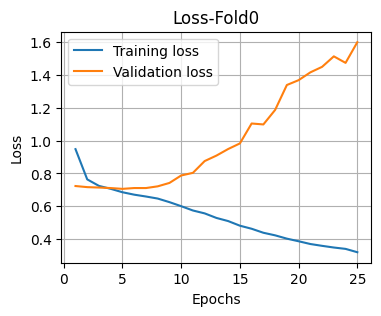

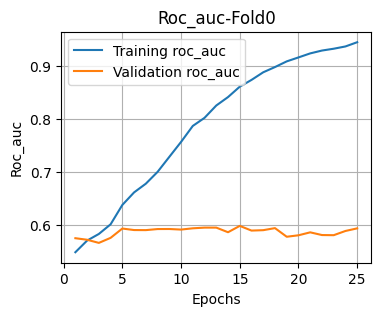

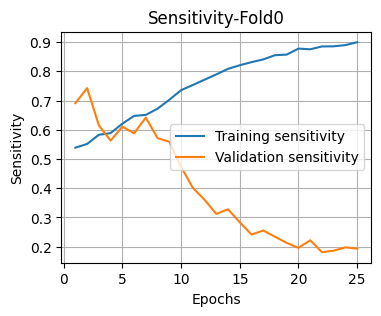

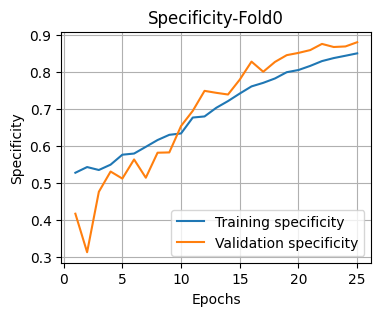

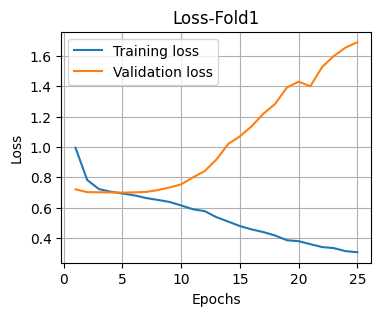

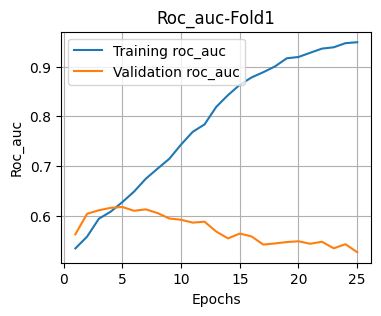

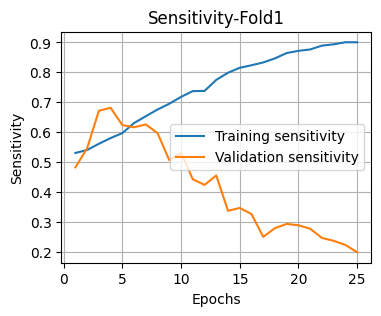

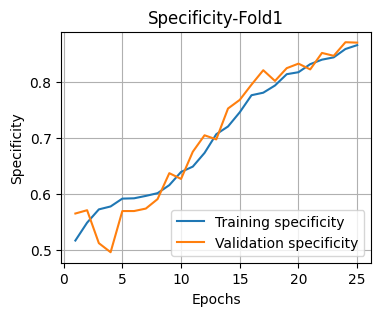

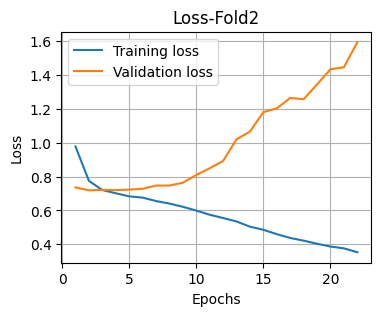

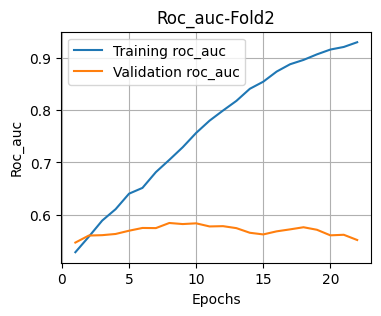

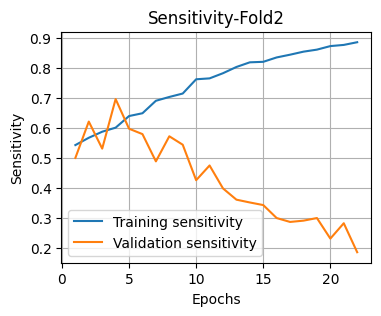

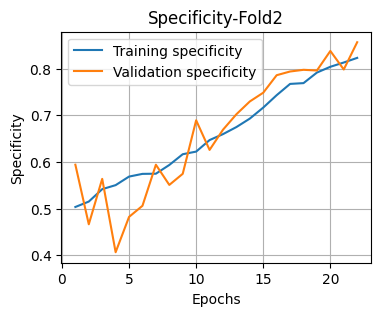

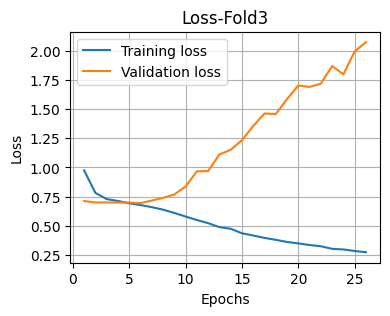

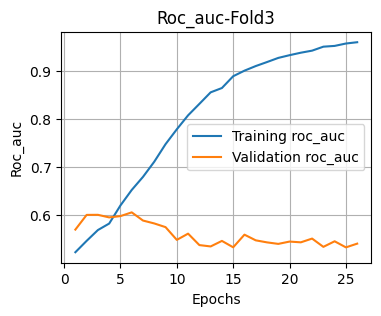

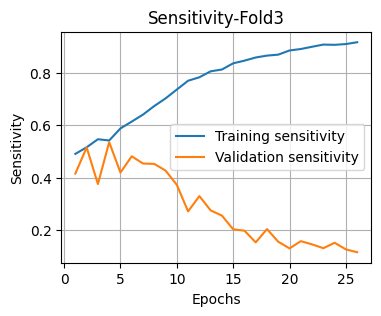

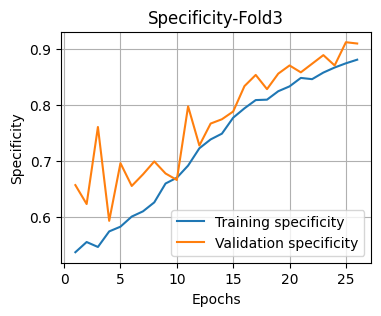

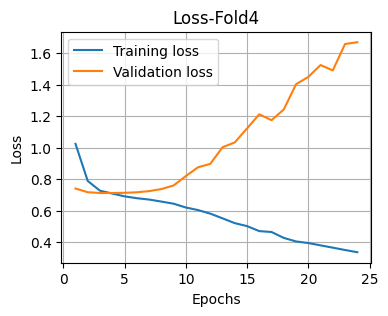

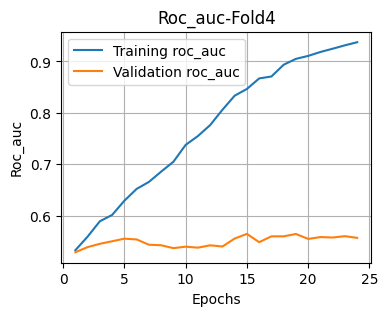

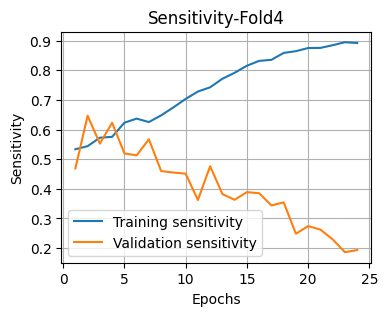

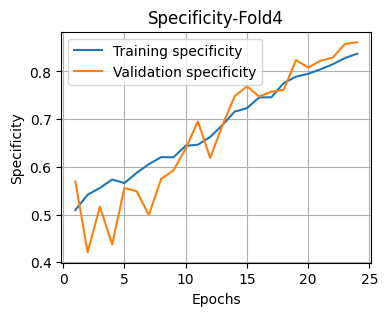

In [49]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    # Extract X
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])

    #  Augment
    aug = TimeWarp(n_speed_change=2, max_speed_ratio=2)
    X_train_aug_os = aug.augment(X_train_nor_os)
    X_val_aug_os   = aug.augment(X_val_nor_os)

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_test_nor.shape[1:], X_delta_test_nor.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_nor_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_nor_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # break

In [50]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0  689  631  35  47     0.573171     0.521970   0.069322  0.123684  0.076630   
1  812  551  31  50     0.617284     0.595745   0.083195  0.146628  0.077133   
2  663  724  31  56     0.643678     0.478010   0.071795  0.129181  0.071105   
3  891  409  48  37     0.435294     0.685385   0.082960  0.139360  0.107300   
4  621  740  31  44     0.586667     0.456282   0.056122  0.102445  0.052873   

    ROC_auc  
0  0.577504  
1  0.620708  
2  0.575458  
3  0.600986  
4  0.530992


Mean ± std across folds:


tn        fp       fn       tp  sensitivity  specificity  \
0     689.0000  631.0000  35.0000  47.0000     0.573171     0.521970   
1     812.0000  551.0000  31.0000  50.0000     0.617284     0.595745   
2     663.0000  724.0000  31.0000  56.0000     0.643678     0.478010   
3     891.0000  409.0000  48.0000  37.0000     0.435294     0.685385   
4     621.0000  740.0000  31.0000  44.0000     0.586667     0.456282   
mean  735.2000  611.0000  35.2000  46.8000     0.571200     0.547500   
std   112.4286  136.2112   7.3621   7.0498     0.080800     0.093700   

      precision  f1_score    PR_auc   ROC_auc  
0      0.069322  0.123684  0.076630  0.577504  
1      0.083195  0.146628  0.077133  0.620708  
2      0.071795  0.129181  0.071105  0.575458  
3      0.082960  0.139360  0.107300  0.600986  
4      0.056122  0.102445  0.052873  0.530992  
mean   0.072700  0.128300  0.077000  0.581100  
std    0.011200  0.016900  0.019600  0.033600

## AddNoise

In [51]:
Dropout = 0.5
Reg_L2 = 1e-4

INIT_LR=5e-4             #	1e-3 ~ 3e-4
WEIGHT_DECAY=1e-2
EPOCHS       = 100
PATIENCE_ES  = 20

BATCH_SIZE = 64


=== Fold 0 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
170/170 - 22s - 128ms/step - loss: 0.9884 - roc_auc: 0.5359 - sensitivity: 0.5282 - specificity: 0.5289 - val_loss: 0.7171 - val_roc_auc: 0.5785 - val_sensitivity: 0.5220 - val_specificity: 0.6205
Epoch 2/100
170/170 - 6s - 33ms/step - loss: 0.7754 - roc_auc: 0.5702 - sensitivity: 0.5395 - specificity: 0.5515 - val_loss: 0.7138 - val_roc_auc: 0.5832 - val_sensitivity: 0.3470 - val_specificity: 0.7538
Epoch 3/100
170/170 - 6s - 33ms/step - loss: 0.7278 - roc_auc: 0.5891 - sensitivity: 0.5592 - specificity: 0.5626 - val_loss: 0.7038 - val_roc_auc: 0.5967 - val_sensitivity: 0.4447 - val_specificity: 0.6992
Epoch 4/100
170/170 - 6s - 34ms/step - loss: 0.7025 - roc_auc: 0.6177 - sensitivity: 0.5853 - specificity: 0.5829 - val_loss: 0.7032 - val_roc_auc: 0.5964 - val_sensitivity: 0.5417 - val_specificity: 0.6220
Epoch 5/100
170/170 - 6s - 35ms/step - loss: 0.6865 - roc_auc: 0.6397 - sensitivity: 0.6084 - specificity: 0.5901 - val_loss: 0.7039 - val_roc_auc: 0.5955 - val_sens

Metric       Value
0   True Negatives  820.000000
1  False Positives  500.000000
2  False Negatives   36.000000
3   True Positives   46.000000
4      Sensitivity    0.560976
5      Specificity    0.621212
6        Precision    0.084249
7         F1 Score    0.146497
8           PR AUC    0.077812
9          ROC AUC    0.594180


=== Fold 1 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
168/168 - 23s - 136ms/step - loss: 0.9760 - roc_auc: 0.5356 - sensitivity: 0.5345 - specificity: 0.5143 - val_loss: 0.7300 - val_roc_auc: 0.5441 - val_sensitivity: 0.3368 - val_specificity: 0.6904
Epoch 2/100
168/168 - 6s - 34ms/step - loss: 0.7614 - roc_auc: 0.5738 - sensitivity: 0.5406 - specificity: 0.5652 - val_loss: 0.7104 - val_roc_auc: 0.5711 - val_sensitivity: 0.4732 - val_specificity: 0.6266
Epoch 3/100
168/168 - 6s - 35ms/step - loss: 0.7207 - roc_auc: 0.5870 - sensitivity: 0.5628 - specificity: 0.5579 - val_loss: 0.7078 - val_roc_auc: 0.5910 - val_sensitivity: 0.3661 - val_specificity: 0.7293
Epoch 4/100
168/168 - 6s - 35ms/step - loss: 0.6997 - roc_auc: 0.6155 - sensitivity: 0.5823 - specificity: 0.5777 - val_loss: 0.7104 - val_roc_auc: 0.5882 - val_sensitivity: 0.3331 - val_specificity: 0.7550
Epoch 5/100
168/168 - 6s - 37ms/step - loss: 0.6872 - roc_auc: 0.6379 - sensitivity: 0.5958 - specificity: 0.5972 - val_loss: 0.7064 - val_roc_auc: 0.5933 - val_sens

Metric       Value
0   True Negatives  829.000000
1  False Positives  534.000000
2  False Negatives   38.000000
3   True Positives   43.000000
4      Sensitivity    0.530864
5      Specificity    0.608217
6        Precision    0.074523
7         F1 Score    0.130699
8           PR AUC    0.071057
9          ROC AUC    0.598471


=== Fold 2 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
167/167 - 18s - 107ms/step - loss: 0.9657 - roc_auc: 0.5308 - sensitivity: 0.5208 - specificity: 0.5262 - val_loss: 0.7047 - val_roc_auc: 0.5759 - val_sensitivity: 0.5717 - val_specificity: 0.5227
Epoch 2/100
167/167 - 5s - 27ms/step - loss: 0.7611 - roc_auc: 0.5676 - sensitivity: 0.5483 - specificity: 0.5443 - val_loss: 0.7012 - val_roc_auc: 0.5979 - val_sensitivity: 0.3504 - val_specificity: 0.7520
Epoch 3/100
167/167 - 5s - 30ms/step - loss: 0.7231 - roc_auc: 0.5814 - sensitivity: 0.5644 - specificity: 0.5576 - val_loss: 0.7026 - val_roc_auc: 0.5818 - val_sensitivity: 0.5926 - val_specificity: 0.5350
Epoch 4/100
167/167 - 5s - 29ms/step - loss: 0.6989 - roc_auc: 0.6140 - sensitivity: 0.5977 - specificity: 0.5588 - val_loss: 0.7048 - val_roc_auc: 0.5833 - val_sensitivity: 0.6121 - val_specificity: 0.5205
Epoch 5/100
167/167 - 5s - 31ms/step - loss: 0.6838 - roc_auc: 0.6376 - sensitivity: 0.6220 - specificity: 0.5758 - val_loss: 0.7057 - val_roc_auc: 0.5794 - val_sens

Metric        Value
0   True Negatives  1044.000000
1  False Positives   343.000000
2  False Negatives    56.000000
3   True Positives    31.000000
4      Sensitivity     0.356322
5      Specificity     0.752704
6        Precision     0.082888
7         F1 Score     0.134490
8           PR AUC     0.079659
9          ROC AUC     0.594386


=== Fold 3 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
170/170 - 23s - 137ms/step - loss: 0.9923 - roc_auc: 0.5261 - sensitivity: 0.5203 - specificity: 0.5133 - val_loss: 0.7096 - val_roc_auc: 0.5692 - val_sensitivity: 0.5692 - val_specificity: 0.5554
Epoch 2/100
170/170 - 7s - 43ms/step - loss: 0.7706 - roc_auc: 0.5641 - sensitivity: 0.5481 - specificity: 0.5312 - val_loss: 0.7046 - val_roc_auc: 0.5708 - val_sensitivity: 0.5562 - val_specificity: 0.5669
Epoch 3/100
170/170 - 6s - 33ms/step - loss: 0.7289 - roc_auc: 0.5763 - sensitivity: 0.5673 - specificity: 0.5421 - val_loss: 0.7029 - val_roc_auc: 0.5793 - val_sensitivity: 0.6485 - val_specificity: 0.4731
Epoch 4/100
170/170 - 6s - 36ms/step - loss: 0.7009 - roc_auc: 0.6079 - sensitivity: 0.5927 - specificity: 0.5550 - val_loss: 0.7002 - val_roc_auc: 0.5969 - val_sensitivity: 0.6315 - val_specificity: 0.5177
Epoch 5/100
170/170 - 5s - 31ms/step - loss: 0.6885 - roc_auc: 0.6300 - sensitivity: 0.6185 - specificity: 0.5684 - val_loss: 0.7017 - val_roc_auc: 0.5948 - val_sens

Metric       Value
0   True Negatives  662.000000
1  False Positives  638.000000
2  False Negatives   30.000000
3   True Positives   55.000000
4      Sensitivity    0.647059
5      Specificity    0.509231
6        Precision    0.079365
7         F1 Score    0.141388
8           PR AUC    0.078240
9          ROC AUC    0.603575


=== Fold 4 ===


Model: "dual_encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 13, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_encoder       │ (None, 64)        │    305,088 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_encoder       │ (None, 64)        │    305,088 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ night_encoder[0]… │
│ (Concatenate)       │                   │            │ delta_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 635,714 (2.43 MB)

 Trainable params: 25,538 (99.76 KB)

 Non-trainable params: 610,176 (2.33 MB)

None
Epoch 1/100
168/168 - 21s - 125ms/step - loss: 0.9703 - roc_auc: 0.5376 - sensitivity: 0.5095 - specificity: 0.5508 - val_loss: 0.7536 - val_roc_auc: 0.5218 - val_sensitivity: 0.2792 - val_specificity: 0.7083
Epoch 2/100
168/168 - 5s - 33ms/step - loss: 0.7766 - roc_auc: 0.5756 - sensitivity: 0.5412 - specificity: 0.5665 - val_loss: 0.7256 - val_roc_auc: 0.5267 - val_sensitivity: 0.4048 - val_specificity: 0.5893
Epoch 3/100
168/168 - 5s - 31ms/step - loss: 0.7250 - roc_auc: 0.5901 - sensitivity: 0.5637 - specificity: 0.5583 - val_loss: 0.7281 - val_roc_auc: 0.5255 - val_sensitivity: 0.2711 - val_specificity: 0.7193
Epoch 4/100
168/168 - 6s - 34ms/step - loss: 0.7009 - roc_auc: 0.6183 - sensitivity: 0.5786 - specificity: 0.6006 - val_loss: 0.7276 - val_roc_auc: 0.5217 - val_sensitivity: 0.3461 - val_specificity: 0.6444
Epoch 5/100
168/168 - 5s - 33ms/step - loss: 0.6843 - roc_auc: 0.6462 - sensitivity: 0.6099 - specificity: 0.5989 - val_loss: 0.7346 - val_roc_auc: 0.5235 - val_sens

Metric       Value
0   True Negatives  813.000000
1  False Positives  548.000000
2  False Negatives   47.000000
3   True Positives   28.000000
4      Sensitivity    0.373333
5      Specificity    0.597355
6        Precision    0.048611
7         F1 Score    0.086022
8           PR AUC    0.050565
9          ROC AUC    0.514984

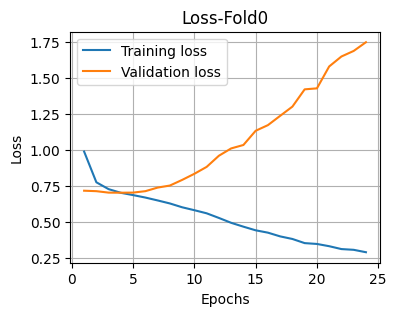

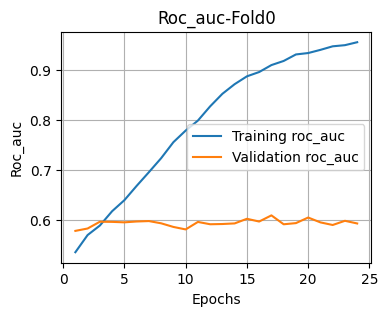

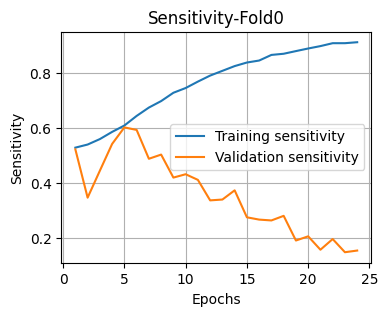

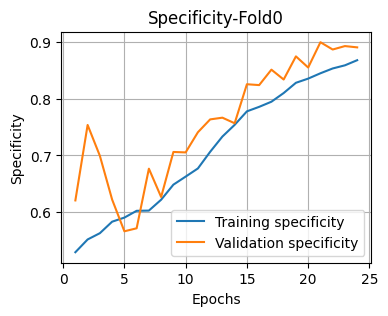

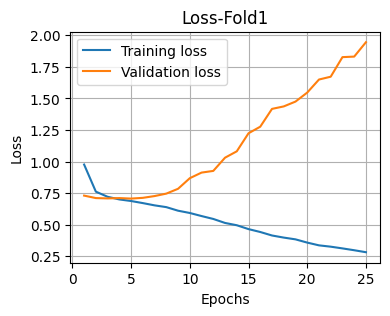

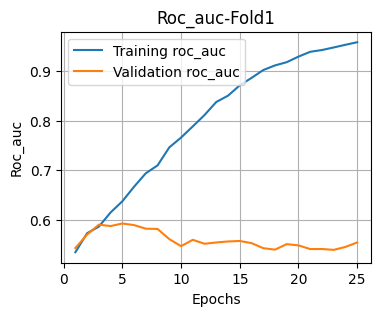

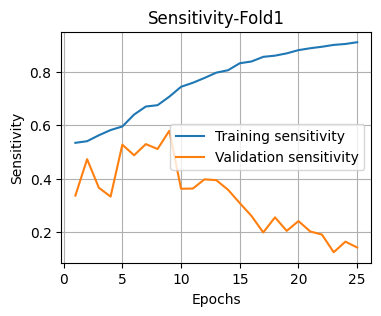

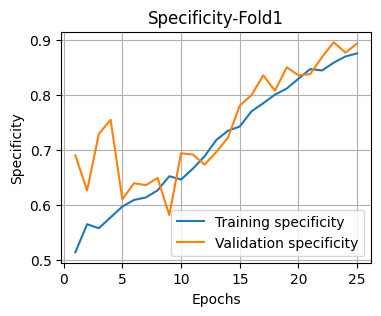

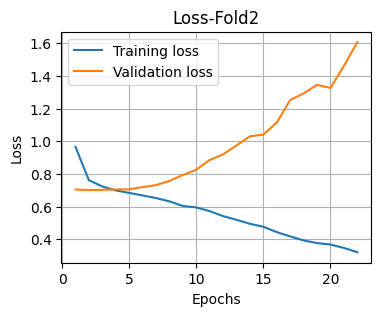

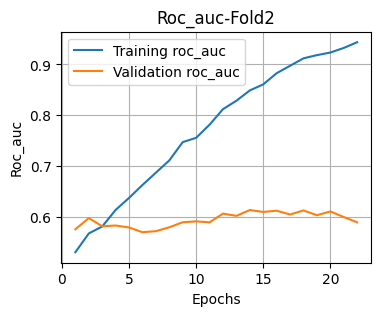

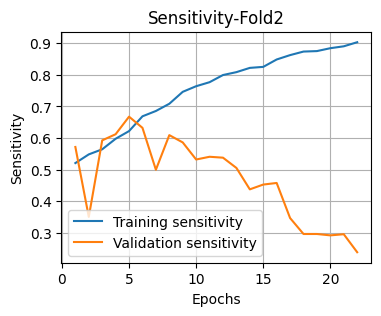

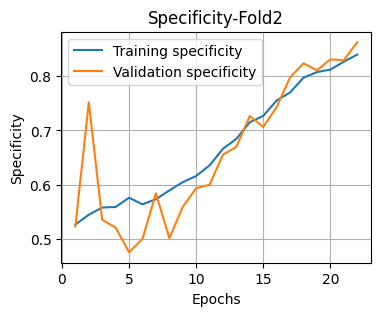

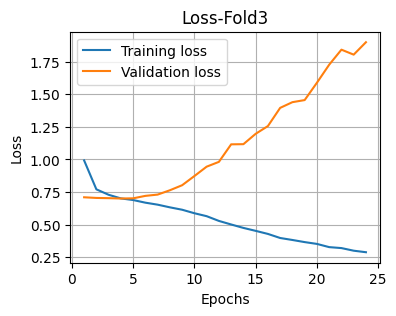

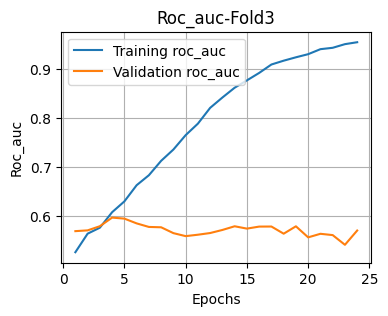

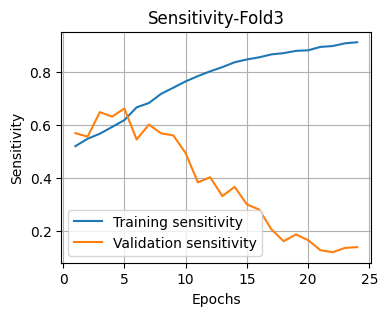

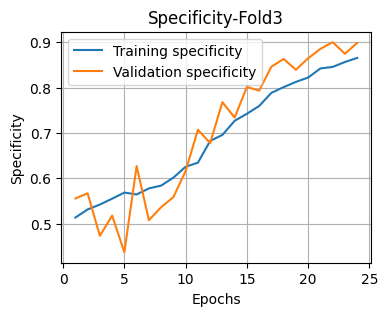

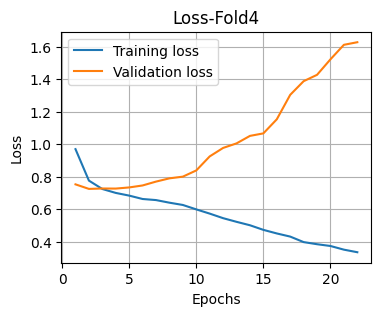

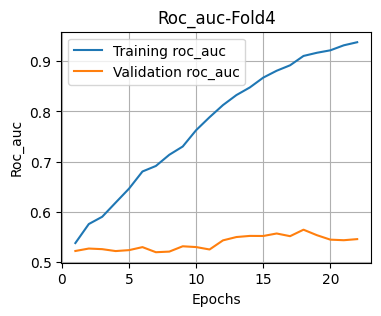

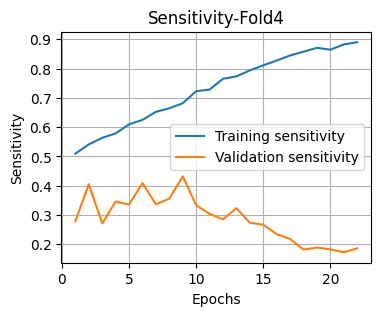

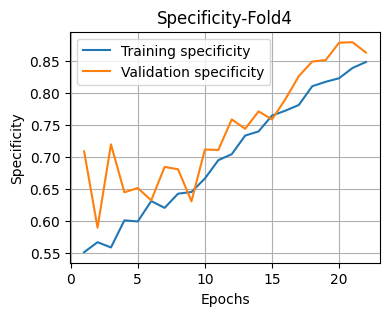

In [52]:
from imblearn.over_sampling import RandomOverSampler
from keras.callbacks import EarlyStopping
from keras import optimizers
# import tensorflow_addons as tfa
# from keras.optimizers import AdamW

cols_needed = ['CurrentNight', 'Delta', "Label", "Fold"]
df = NightAndDelta_dataset_Continuous[cols_needed].copy()

metric_names = [
    "tn", "fp", "fn", "tp",
    "sensitivity", "specificity",
    "precision", "f1_score",
    "PR_auc", "ROC_auc"
]
metrics = {name: [] for name in metric_names}
history_record = {}

for fold in sorted(df["Fold"].unique()):
    print(f"\n=== Fold {fold} ===")
    # Clear the previous TF graph to avoid memory leaks
    tf.keras.backend.clear_session()
    # ── Stage 0: Data Preprocess ─────────────────────────────────────────────────────
    #   split by the pre-assigned Fold column
    train_df = df[df["Fold"] != fold].copy()
    val_df   = df[df["Fold"] == fold].copy()

    #   normalize
    scaler = fit_minmax_scaler(np.stack(train_df["CurrentNight"].to_numpy()))
    train_df.loc[:, 'Nor_X'] = train_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    val_df.loc[:, 'Nor_X'] = val_df['CurrentNight'].apply(lambda x: normalize_with_scaler(x, scaler))
    delta_scaler = fit_minmax_scaler(np.stack(train_df['Delta'].to_numpy()))
    train_df.loc[:, 'Nor_delta'] = train_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    val_df.loc[:, 'Nor_delta'] = val_df['Delta'].apply(lambda x: normalize_with_scaler(x, delta_scaler))
    #   testset (without mask and oversampling)
    X_test_nor, X_delta_test_nor = np.stack(val_df["Nor_X"].to_numpy()), np.stack(val_df['Nor_delta'])    # (N, T, F)
    y_test  = val_df["Label"].to_numpy(dtype=np.int32)

    #  apply minority class oversampling to training and validation folds separately
    #  for learning curve analysis
    train_balanced_df = oversample_binary_df(train_df, target_column='Label', random_state=42)
    val_balanced_df = oversample_binary_df(val_df, target_column='Label', random_state=42)

    # Extract X
    X_train_nor_os, X_train_delta_nor_os = np.stack(train_balanced_df["Nor_X"].to_numpy()), np.stack(train_balanced_df['Nor_delta'])
    X_val_nor_os,   X_val_delta_nor_os   = np.stack(val_balanced_df["Nor_X"].to_numpy()), np.stack(val_balanced_df['Nor_delta'])

    #  Augment
    aug = AddNoise(scale=0.05)
    X_train_aug_os = aug.augment(X_train_nor_os)
    X_val_aug_os   = aug.augment(X_val_nor_os)

    #   extract y
    Y_train_os = to_categorical(train_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)
    Y_val_os   = to_categorical(val_balanced_df["Label"].to_numpy(dtype=np.int32), num_classes=2)


    # ───────────────── Training ───────────────────────────────────────────────
    # Init Classifier
    input_shape_li = (X_test_nor.shape[1:], X_delta_test_nor.shape[1:])
    # Clone the **model architecture** in memory – fast, no disk I/O
    raw_enc   = tf.keras.models.clone_model(encoders[0])
    delta_enc = tf.keras.models.clone_model(encoders[1])
    # Restore the saved initial weights.
    raw_enc.set_weights(raw_init_w)
    delta_enc.set_weights(delta_init_w)
    classification_model = classification_2encoder(input_shape_li,
                                                   (raw_enc, delta_enc),
                                                   freeze_encoders=True,
                                                   mlp_dropout_rate=Dropout,
                                                   regularizers_l2=Reg_L2)
    print(classification_model.summary())
    # keras.utils.plot_model(classification_model, show_shapes=True, show_layer_names=True)

    # Compile classification model with metrics
    # opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    opt = optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
    classification_model.compile(optimizer=opt,
                                 loss='categorical_crossentropy',
                                 metrics=[
                                    #  tf.keras.metrics.AUC(curve='PR', multi_label=True,label_weights=[0,1],name='pr_auc'),
                                     tf.keras.metrics.AUC(curve='ROC', multi_label=True,label_weights=[0,1],name='roc_auc'),
                                     tf.keras.metrics.Recall(class_id=1, name="sensitivity"),
                                     tf.keras.metrics.Recall(class_id=0, name="specificity"),
                                    #  tfa.metrics.F1Score(num_classes=2,
                                    #                       average='macro',
                                    #                       threshold=0.5,
                                    #                       name='f1'),
                                     ]
                                 )
    # Define the callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=PATIENCE_ES,          # Number of epochs to wait before stopping if no improvement
        verbose=1,           # Prints a message when training stops
        restore_best_weights=True,  # Restores the weights from the best epoch
        min_delta=1e-5
    )
    # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=FACTOR, patience=PATIENCE, verbose=1,
    #     min_lr=MIN_LR)
    # Train classification model
    history = classification_model.fit([X_train_aug_os, X_train_delta_nor_os], # two inputs
                                       Y_train_os,
                                       validation_data=(
                                           [X_val_aug_os, X_val_delta_nor_os], Y_val_os
                                           ),
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       verbose=2,
                                       callbacks=[early_stopping
                                                  # ,lr_scheduler
                                                  ]       # Pass the callback here
                                       )
    history_record[fold] = history

    # ───────────────── Stage 2: Evaluation ────────────────────────────────────
    # Plot learning curves for the reconstruction model
    plot_learning_curves(history, name=f'Fold{fold}', metric_name_li=['loss', 'roc_auc', 'sensitivity', 'specificity'])
    # Evaluate classification model
    y_val_pred_probs = classification_model.predict([X_test_nor, X_delta_test_nor])
    y_val_true = y_test #(n,)
    # Use the evaluation function to update metrics
    evaluate_model(y_val_true, y_val_pred_probs, metrics)

    # break

In [53]:
print("Dropout", Dropout, 'Reg_L2', Reg_L2)
# ------------------------------------------------------------------
# Display all folds + an aggregate summary
# ------------------------------------------------------------------
metrics_df = pd.DataFrame(metrics)
print("\nPer-fold metrics:")
display(metrics_df)

print("\nMean ± std across folds:")
summary_df = metrics_df.agg(["mean", "std"]).round(4)
display(pd.concat([metrics_df,summary_df]))

Dropout 0.5 Reg_L2 0.0001

Per-fold metrics:


tn   fp  fn  tp  sensitivity  specificity  precision  f1_score    PR_auc  \
0   820  500  36  46     0.560976     0.621212   0.084249  0.146497  0.077812   
1   829  534  38  43     0.530864     0.608217   0.074523  0.130699  0.071057   
2  1044  343  56  31     0.356322     0.752704   0.082888  0.134490  0.079659   
3   662  638  30  55     0.647059     0.509231   0.079365  0.141388  0.078240   
4   813  548  47  28     0.373333     0.597355   0.048611  0.086022  0.050565   

    ROC_auc  
0  0.594180  
1  0.598471  
2  0.594386  
3  0.603575  
4  0.514984


Mean ± std across folds:


tn        fp       fn       tp  sensitivity  specificity  \
0      820.0000  500.0000  36.0000  46.0000     0.560976     0.621212   
1      829.0000  534.0000  38.0000  43.0000     0.530864     0.608217   
2     1044.0000  343.0000  56.0000  31.0000     0.356322     0.752704   
3      662.0000  638.0000  30.0000  55.0000     0.647059     0.509231   
4      813.0000  548.0000  47.0000  28.0000     0.373333     0.597355   
mean   833.6000  512.6000  41.4000  40.6000     0.493700     0.617700   
std    136.3316  107.6559  10.1882  11.1041     0.125300     0.087300   

      precision  f1_score    PR_auc   ROC_auc  
0      0.084249  0.146497  0.077812  0.594180  
1      0.074523  0.130699  0.071057  0.598471  
2      0.082888  0.134490  0.079659  0.594386  
3      0.079365  0.141388  0.078240  0.603575  
4      0.048611  0.086022  0.050565  0.514984  
mean   0.073900  0.127800  0.071500  0.581100  
std    0.014600  0.024100  0.012100  0.037200